Перед началом работы над проектом импортируем необходимые инструменты:

In [1]:
# Установка и обновление необходимых библиотек:
!pip install seaborn==0.13.0 -q
!pip install --upgrade scikit-learn -q
!pip install --upgrade phik -q

In [2]:
# Импорт необходимых библиотек и модулей:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from warnings import simplefilter

# Импорт инструментов корреляционного анализа:
from phik import phik_matrix
from phik.report import plot_correlation_matrix

# Импорт инструментов подготвки данных:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Импорт инструмента подбора гиперпараметров:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

# Импорт моделей МО:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Импорт дамми-модели для проверки адекватности моделей:
from sklearn.dummy import DummyClassifier

# Импорт функции метрик:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# Импорт функции построения матрицы ошибок модели:
from sklearn.metrics import confusion_matrix

# Импорт функции построения ROC-кривой:
from sklearn.metrics import RocCurveDisplay

In [3]:
# Дополнительные действия:

# Доп. настройка сетки для графиков:
sns.set_style("darkgrid", {'grid.color': 'gray'})

# Доп. настройка для размера графиков seaborn:
sns.set_theme(rc={'figure.figsize': (9, 6)})

# Отключение предупреждений:
simplefilter(action='ignore')

# Объявление констант:
RANDOM_STATE = 140725
TEST_SIZE = 0.25

## Ознакомление

После импортирования необходимых инструментов считаем и сохраним полученный датасет. Далее проверим корректность считывания:

In [4]:
# Считывание и сохранение полученных датасетов:
contract_data = pd.read_csv('/datasets/contract_new.csv')
personal_data = pd.read_csv('/datasets/personal_new.csv')
internet_data = pd.read_csv('/datasets/internet_new.csv')
phone_data = pd.read_csv('/datasets/phone_new.csv')

# Проверка считывания:
display(contract_data.head(2), personal_data.head(2), internet_data.head(2), phone_data.head(2))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No


Данные считаны и сохранены корректно, названия и содержание столбцов не противоречит заявленным. Однако для удобства приведём названия столбцов к корректному виду. Объявим для этого функцию:

In [5]:
# Функция для корректировки имён признаков:
def get_correct_feature_names(df):
    df.columns = df.columns.str.replace(r'([a-z])([A-Z])', r'\1_\2', regex=True).str.lower()
    return df

Изменим имена признаков с помощью цикла:

In [6]:
# Создание списка с таблицами:
sample_list = [contract_data, personal_data, internet_data, phone_data]
sample_names = ['contract_data', 'personal_data', 'internet_data', 'phone_data']

# Применеие цикла:
for name, sample in zip(sample_names, sample_list):
    sample = get_correct_feature_names(sample)
    print(f'\033[94mТаблица {name}\033[0m:')
    print(f'Имена признаков после изменения: {sample.columns.values}\n\n')

Таблица contract_data:
Имена признаков после изменения: ['customer_id' 'begin_date' 'end_date' 'type' 'paperless_billing'
 'payment_method' 'monthly_charges' 'total_charges']


Таблица personal_data:
Имена признаков после изменения: ['customer_id' 'gender' 'senior_citizen' 'partner' 'dependents']


Таблица internet_data:
Имена признаков после изменения: ['customer_id' 'internet_service' 'online_security' 'online_backup'
 'device_protection' 'tech_support' 'streaming_tv' 'streaming_movies']


Таблица phone_data:
Имена признаков после изменения: ['customer_id' 'multiple_lines']




Рассмотрим общую информацию о датасетах. Для лаконичности кода и отсутствия повторов в будущем, объявим функцию:

In [7]:
# Объявление функции для просмотра информации:
def view_common_info(df_list: list, names_list: list):
    for name, sample in zip(names_list, df_list):
        print(f'\033[94mТаблица {name}\033[0m:\n')
        print(sample.info())
        print(f'Объектов: {sample.shape[0]}; признаков: {sample.shape[1]}')
        print('-' * 100, '\n\n')

In [8]:
# Применение фукнции:
view_common_info(sample_list, sample_names)

Таблица contract_data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None
Объектов: 7043; признаков: 8
---------------------------------------------------------------------------------------------------- 


Таблица personal_data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          ---

Также дополнительно можно сразу посмотреть на наличие **явных** дубликатов. Сделаем это также с помощью функции:

In [9]:
# Функция для проверки наличия явных дубликатов:
def check_duplicates(df):
    print(f'Кол-во явных дубликатов в датасете: {df.duplicated().sum()}')

    if df.duplicated().sum() != 0:
        df.drop_duplicates(ignore_index=True, inplace=True)
        # Проверка:
        print(f'\nКол-во явных дубликатов после обработки: {df.duplicated().sum()}')
        print(f'Кол-во объектов в датасете: {df.shape[0]}')
    else:
        print('Явных дубликатов не обнаружено.\n')

Проверим для каждого датасета:

In [10]:
# Проверка наличия явных дубликатов:
for sample, name in zip(sample_list, sample_names):
    print(f'\033[94mТаблица {name}\033[0m:')
    check_duplicates(sample)

Таблица contract_data:
Кол-во явных дубликатов в датасете: 0
Явных дубликатов не обнаружено.

Таблица personal_data:
Кол-во явных дубликатов в датасете: 0
Явных дубликатов не обнаружено.

Таблица internet_data:
Кол-во явных дубликатов в датасете: 0
Явных дубликатов не обнаружено.

Таблица phone_data:
Кол-во явных дубликатов в датасете: 0
Явных дубликатов не обнаружено.



### Выводы
На данном этапе:

- Были корректно считаны и сохранены таблицы.
- Были изменены наименования признаков согласно _snakecase_.
- _Явных_ пропусков не обнаружено.
-  _Явных_ дубликатов не обнаружено.
-  2/4 таблиц не совпадают с остальными по количеству объектов.
- Есть несоответствие у ряда признаков по типу данных.

Переходим к этапу предобработки данных.

## Предобработка данных

Для начала посмотрим для каждого датасета перечень уникальных значений:

In [11]:
# Реализуем циклом:
for sample, name in zip(sample_list, sample_names):
    print(f'\033[94mТаблица {name}\033[0m:\n')
    for column in sample.columns:
        print(f'Уникальные значения столбца {column}\n: {sample[column].unique()}')
        print(f'Количество: {sample[column].nunique()}\n')
    print('-' * 120)

Таблица contract_data:

Уникальные значения столбца customer_id
: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Количество: 7043

Уникальные значения столбца begin_date
: ['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-01' '2014-10-01' '2015-06-01' '2016-08-01' '2019-05-01'
 '2017-03-01' '2016-02-01' '2017-09-01' '2014-09-01' '2017-12-01'
 '2016-12-01' '2017-06-01' '2015-05-01' '2016-10-01' '2016-09-01'
 '2019-08-01' '2019-07-01' '2017-05-01' '2017-10-01' '2014-07-01

Несколько инсайтов:<br>
- Наблюдаем множество бинарных признаков. Значения `Yes`/`No` заменим числовыми `1`/`0` для удобства.<br><br>

- Столбец `customer_id` изменениям подвергаться не будет, по нему мы будем объединять данные после анализа.<br><br>

- Числовые столбцы с непревывными значениями (их всего 2) изменим на тип данных `float`. Во избежание некорректных значений в них (_**неявные пропуски**_) настроим определённые параметры в функциях для изменений типов данных.<br><br>

- В столбце `end_data` наблюдаем помимо дат значение `No`, причём оно самое частое, т.к. стоит первым в списке. _Оно означает, что клиент не прекращал сотрудничество с компанией. Мы можем использовать эту информацию для создания `целевого признака`._<br><br>

- В этом же столбце значение `No` даст больше всего пропусков, т.к. функция не сможет преобразовать его в дату.

Обратим внимание на то, что бинарные категориальные признаки будут принимать всего два значения, поэтому их приведём к типу `int8` для оптимизации занимаемой памяти. Рассмотрим, к какому типу лучше привести непрерывные признаки:

In [12]:
for column in contract_data.columns[-2:]:
    print(f'Диапазон {column}: от {contract_data[column].min()} до {contract_data[column].max()}')

Диапазон monthly_charges: от 18.25 до 118.75
Диапазон total_charges: от   до 999.9


Их приведём к типу `float32`.<br><br> P.S.:<br>Сначала я попробовал тип `float16`, но потом возникли проблемы с расчётом среднего арифметического, на их месте было значение `inf`.

Теперь исправим типы данных столбцов с помощью объявленной функции. Некоторые параметры функций (например, поведение при ошибках) будут определены вышеперечисленными инсайтами:

In [13]:
# Объявляем функцию для изменения типов данных признаков:
def change_dtypes(df: pd.core.frame.DataFrame,
                  str_cols: list = None, num_cols: list = None,
                  date_cols: list = None, binary_cols: list = None,
                  num_type: str = 'float32', date_format: str = None,
                  old_bin_val: list = None, new_bin_val: list = None):
    
    if str_cols is not None:
        df[str_cols] = df[str_cols].astype('str')
        for col in str_cols:
            df[col] = df[col].str.lower()
    
    if num_cols is not None:
        for col in num_cols:
            df[col] = pd.to_numeric(df[col], errors='coerce').astype(num_type)
    
    if date_cols is not None:
        for col in date_cols:
            df[col] = pd.to_datetime(df[col], format=date_format, errors='coerce')
    
    if binary_cols is not None:
        for col in binary_cols:
            if any(val in ['Yes', 'No'] or val in ['No', 'Yes'] for val in df[col].unique()):
                df[col] = df[col].apply(
                    lambda x: new_bin_val[0] if x==old_bin_val[0] else new_bin_val[1])
            df[col] = df[col].astype('int8')
    
    return df

Применяем объявленную функцию для изменения типов данных:

In [14]:
# Применение функции:
contract_data = change_dtypes(
    df=contract_data, str_cols=['type', 'payment_method'],
    num_cols=['monthly_charges', 'total_charges'], date_cols=['begin_date', 'end_date'],
    date_format='%Y-%m-%d', binary_cols=['paperless_billing'],
    old_bin_val=['Yes', 'No'], new_bin_val=[1, 0]
)

personal_data = change_dtypes(
    df=personal_data, str_cols=['gender'], 
    binary_cols=['partner', 'dependents', 'senior_citizen'],
    old_bin_val=['Yes', 'No'], new_bin_val=[1, 0]
)

internet_data = change_dtypes(
    df=internet_data, str_cols=['internet_service'],
    binary_cols=list(internet_data.columns[2:]),
    old_bin_val=['Yes', 'No'], new_bin_val=[1, 0]
)

phone_data = change_dtypes(
    df=phone_data, binary_cols=['multiple_lines'],
    old_bin_val=['Yes', 'No'], new_bin_val=[1, 0]
)

Выполним проверку:

In [15]:
# Применияем ранее объявленную функцию:
view_common_info(sample_list, sample_names)

Таблица contract_data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1101 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   int8          
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float32       
 7   total_charges      7032 non-null   float32       
dtypes: datetime64[ns](2), float32(2), int8(1), object(3)
memory usage: 337.1+ KB
None
Объектов: 7043; признаков: 8
---------------------------------------------------------------------------------------------------- 


Таблица personal_data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Da

Таким образом, мы изменили типы данных во всех признаках таблиц. Однако, в датасете `contract_data` образовались пропуски: значительное кол-во в столбце `end_date` и почти дюжина (11 шт.) в столбце `total_charges`.<br><br>
Это произошло по причине того, что значения были некорректными и функции `pd.to_numeric()`/`pd.to_datetime()` присвоили им значения `NaN`.<br>
Посмотрим, что там было до преобразований. Загрузим повторно необработанную таблицу:

In [16]:
# Загрузим заново таблицу:
temporary = pd.read_csv('/datasets/contract_new.csv')

# Проверка:
temporary.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


С помощью метода `value_counts()` найдём некорректное значение среди множества всех значений. Найдем минимальное по **лексикографическому порядку**:

In [17]:
# Поиск мин. значения:
print('Мин. значение по лексикограф. порядку:')
temporary['TotalCharges'].value_counts().index.min()

Мин. значение по лексикограф. порядку:


' '

Обнаружен неявный пропуск в виде строки, содержащей пробел. Посмотрим на сами объекты с таким значением и их кол-во:

In [18]:
# Взглянем на объекты:
display(temporary[temporary['TotalCharges'] == ' '])
print('Кол-во объектов:',
      temporary[temporary['TotalCharges'] == ' ']['Type'].count())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Кол-во объектов: 11


Вот и наши 11 объектов с некорректным значением признака `total_charges`, которые вылились в значения NaN.<br><br>
Дополнительно убедимся в том, что все пропуски в столбце `end_date` образовались из-за некорректного для перевода в дату значения `No`. Для этого узнаем, сколько объектов обладают таким значением:

In [19]:
# Выведем кол-во объектов со значением 'No':
print('Кол-во объектов:', temporary['EndDate'].value_counts()[0])

Кол-во объектов: 5942


Сравним с кол-вом пропусков в нашей основной таблице:

In [20]:
# Выведем кол-во пропусков:
print('Кол-во пропусков:', contract_data['end_date'].isna().sum())

Кол-во пропусков: 5942


Как мы видим, оно одинаковое. Значит, все пропуски именно из-за значения `No`.<br>
Временная повторная таблица больше не понадобится, удалим её за ненадобностью.

In [21]:
# Удаление временной таблицы:
del temporary

Таким образом, мы выявили причину образования пропусков.

### Образование целевого признака
Удалять пропуски, конечно, не будем. Мы сможем образовать целевой признак `target` и, например, ещё один входной признак с _длительностью действия договора с клиентом_.<br><br>


Образуем целевой признак, который будет бинарным:

In [22]:
# Образуем "скелет":
contract_data['target'] = 0

# Добавим единицы, где надо:
contract_data['target'] = contract_data['end_date'].apply(
    lambda x: 0 if pd.isna(x) else 1)

# Изменим тип данных:
contract_data['target'] = contract_data['target'].astype('int8')

# Проверка:
print(f"Уникальные значения целевого признака: {contract_data['target'].unique()}")
print(f"Тип данных целевого признака: {contract_data['target'].dtype}")

# Проверочные срезы:
display(contract_data[contract_data['target'] == 1].head(3))
display(contract_data[contract_data['target'] == 0].head(3))

Уникальные значения целевого признака: [0 1]
Тип данных целевого признака: int8


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target
9,6388-TABGU,2014-12-01,2017-05-01,one year,0,bank transfer (automatic),56.150002,1628.349976,1
15,3655-SNQYZ,2014-05-01,2016-03-01,two year,0,credit card (automatic),113.250000,2491.500000,1
25,6865-JZNKO,2017-08-01,2018-09-01,month-to-month,1,bank transfer (automatic),55.299999,726.090027,1


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target
0,7590-VHVEG,2020-01-01,NaT,month-to-month,1,electronic check,29.850000,31.040001,0
1,5575-GNVDE,2017-04-01,NaT,one year,0,mailed check,56.950001,2071.840088,0
2,3668-QPYBK,2019-10-01,NaT,month-to-month,1,mailed check,53.849998,226.169998,0


Таким образом, значение целевого признака `1` теперь у клиентов, которые окончили договор, и `0` у тех, кто не заканчивал сотрудничество.<br><br>


Образуем ещё один признак, входной. Он будет отвечать за длительность договора клиента. Если значение `end_date` отсутствует, будем считать от даты среза — **_01.02.2020_**.<br>
Для удобства заполним пропуски в `end_date` _**этой датой**_, чтобы затем вычесть столбец `begin_data` из `end_data` и получить количество дней. Они и будут значениями нового входного признака. 


In [23]:
# Заполним пропуски актуальной датой:
contract_data['end_date'].fillna(pd.Timestamp('2020-02-01'), inplace=True)

# Проверка:
print(f"Теперь пропусков: {contract_data['end_date'].isna().sum()}")

Теперь пропусков: 0


Создадим новый столбец **`duration`** с помощью вычитания дат:

In [24]:
# Создание нового признака:
contract_data['duration'] = contract_data['end_date'] - contract_data['begin_date']

# Проверка:
display(contract_data.head())
print(f"Тип данных duration: {contract_data['duration'].dtype}")

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target,duration
0,7590-VHVEG,2020-01-01,2020-02-01,month-to-month,1,electronic check,29.850000,31.040001,0,31 days
1,5575-GNVDE,2017-04-01,2020-02-01,one year,0,mailed check,56.950001,2071.840088,0,1036 days
2,3668-QPYBK,2019-10-01,2020-02-01,month-to-month,1,mailed check,53.849998,226.169998,0,123 days
3,7795-CFOCW,2016-05-01,2020-02-01,one year,0,bank transfer (automatic),42.299999,1960.599976,0,1371 days
4,9237-HQITU,2019-09-01,2020-02-01,month-to-month,1,electronic check,70.699997,353.500000,0,153 days


Тип данных duration: timedelta64[ns]


Изменим тип данных для удобства в будущем анализе:

In [25]:
# Меняем тип данных:
contract_data['duration'] = \
contract_data['duration'].astype('timedelta64[D]').astype('int16')

# Проверка:
display(pd.DataFrame(contract_data['duration'].head()))
print(f"Тип данных duration: {contract_data['duration'].dtype}")

,duration
0,31
1,1036
2,123
3,1371
4,153


Тип данных duration: int16


Осталось разобраться с пропусками для `total_charges`. Посмотрим еще раз на эти объекты:

In [26]:
# Сделаем срез:
display(contract_data[contract_data['total_charges'].isna()])

# Сохраним индексы этих объектов для будущей проверки:
indexes = contract_data[contract_data['total_charges'].isna()].index.tolist()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target,duration
488,4472-LVYGI,2020-02-01,2020-02-01,two year,1,bank transfer (automatic),52.549999,NaN,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,two year,0,mailed check,20.250000,NaN,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,two year,0,mailed check,80.849998,NaN,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,two year,0,mailed check,25.750000,NaN,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,two year,0,credit card (automatic),56.049999,NaN,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,two year,0,mailed check,19.850000,NaN,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,two year,0,mailed check,25.350000,NaN,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,two year,0,mailed check,20.000000,NaN,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,one year,1,mailed check,19.700001,NaN,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,two year,0,mailed check,73.349998,NaN,0,0


_Заметим, что у всех дата начала подписания договора — последняя актуальная дата._<br>
Следовательно, пропуски такие могли образоваться при выгрузке данных, т.к. у таких клиентов просто отсутствуют суммарные затраты.<br><br>
Логично предположить, что такие клиенты при подписании договора как раз и оплачивали сумму из `monthly_charges`, но _она могла не успеть поступить на банковский счёт._<br><br>

Продублируем эту сумму в `total_charges`, т.к. это их единственная оплата.

In [27]:
# Заполним пропуски:
contract_data['total_charges'].fillna(
    contract_data['monthly_charges'], inplace=True)

# Проверка:
display(contract_data.iloc[indexes])
print(f"Кол-во пропусков в таблице: {contract_data.isna().sum().sum()}")

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target,duration
488,4472-LVYGI,2020-02-01,2020-02-01,two year,1,bank transfer (automatic),52.549999,52.549999,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,two year,0,mailed check,20.250000,20.250000,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,two year,0,mailed check,80.849998,80.849998,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,two year,0,mailed check,25.750000,25.750000,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,two year,0,credit card (automatic),56.049999,56.049999,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,two year,0,mailed check,19.850000,19.850000,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,two year,0,mailed check,25.350000,25.350000,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,two year,0,mailed check,20.000000,20.000000,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,one year,1,mailed check,19.700001,19.700001,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,two year,0,mailed check,73.349998,73.349998,0,0


Кол-во пропусков в таблице: 0


Теперь, когда мы заполнили пропуски и образовали новые признаки, старые нам больше не понадобятся. Убираем их:

In [28]:
# Убираем признаки:
contract_data.drop(['begin_date', 'end_date'], axis=1, inplace=True)

# Проверка:
print(f'Новый набор признаков contract_data: {contract_data.columns.values}\n')
contract_data.head(3)

Новый набор признаков contract_data: ['customer_id' 'type' 'paperless_billing' 'payment_method'
 'monthly_charges' 'total_charges' 'target' 'duration']



,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,target,duration
0,7590-VHVEG,month-to-month,1,electronic check,29.850000,31.040001,0,31
1,5575-GNVDE,one year,0,mailed check,56.950001,2071.840088,0,1036
2,3668-QPYBK,month-to-month,1,mailed check,53.849998,226.169998,0,123


Убрали признаки, и теоретически могут появиться явные дубликаты. Лучше проверить:

In [29]:
# Проверка на явные дубликаты:
check_duplicates(contract_data)

Кол-во явных дубликатов в датасете: 0
Явных дубликатов не обнаружено.



### Выводы

Таким образом, на данном этапе мы:
- избавились от пропусков;
- образовали новые признаки;
- избавились от пары старых признаков.

## EDA

Проанализируем признаки в каждом датасете (кроме признака `customer_id`). Начнём с датасета **`contract_data`**.

### contract_data

#### Количественные признаки

Рассмотрим основные числовые характеристики количественных признаков:

In [30]:
# Убираем категориальные и выводим хар-ки:
contract_data.drop(['paperless_billing', 'target'], axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
monthly_charges,7043.0,64.761696,30.090048,18.250000,35.50,70.349998,89.849998,118.750000
total_charges,7043.0,2115.377441,2112.678955,19.049999,436.75,1343.349976,3236.689941,9221.379883
duration,7043.0,898.555729,683.130510,0.000000,276.00,761.000000,1461.000000,2314.000000


В датасете всего три таких признака: _непрерывные_ `monthly_charges` и `total_charges` и _дискретный_ `duration`.<br><br>

Несколько первичных выводов:
- среднее медианное расходов за месяц у абонентов — 70 единиц.
- у `total_charges` (расходы за всё время) 4-ый квартиль в несколько раз отличается от 3-го, что говорит нам о наличии выбросов/аномальных значений. Необходим более детальный анализ. Среднее медианное — 1343 единицы.
- из-за наличия совсем новых абонентов в `duration` минимальное значение 0 дней.
- в полученной выборке абоненты в среднем сотрудничают **почти 900 дней**.<br><br>


Объявим несколько функций, чтобы было удобно анализировать данные:

In [31]:
# Отделение количественных признаков:
def get_num_cols(df, exception: list = None):
    num_cols = df.select_dtypes(include='number').columns.tolist()
    if exception is not None:
        num_cols = [col for col in num_cols if col not in exception]
    return num_cols

In [32]:
# Функция для анализа непрерывных признаков:
def num_col_analyse(df, column, xlabel: str = '', bins: int = 10):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    # Построение гистограммы:
    axes[0].hist(df[column], bins=bins)
    axes[0].set_ylabel('Кол-во объектов', fontsize=12)
    axes[0].set_xlabel(xlabel, fontsize=12)
    axes[0].set_title('Гистограмма ' + str(column),
                     fontsize=14)
    axes[0].grid(True, color='orange')
    
    # Построение диаграммы размаха:
    boxplot = plt.boxplot(df[column])
    axes[1].boxplot
    axes[1].set_xlabel('Значения', fontsize=11)
    axes[1].set_title('Диаграмма размаха ' + str(column),
                     fontsize=14)
    axes[1].grid(True, color='orange')
    
    outliers = list(boxplot["fliers"][0].get_data()[1])
    print(f'\nКол-во выбросов: {len(outliers)}') 
    
    return plt.show()

Приступим к анализу признаков:

In [33]:
# Получаем список числовых признаков для анализа:
num_cols = get_num_cols(contract_data, exception=['paperless_billing', 'target'])

# Проверка:
print(f'Числовые признаки для анализа: {num_cols}')

Числовые признаки для анализа: ['monthly_charges', 'total_charges', 'duration']



Кол-во выбросов: 0


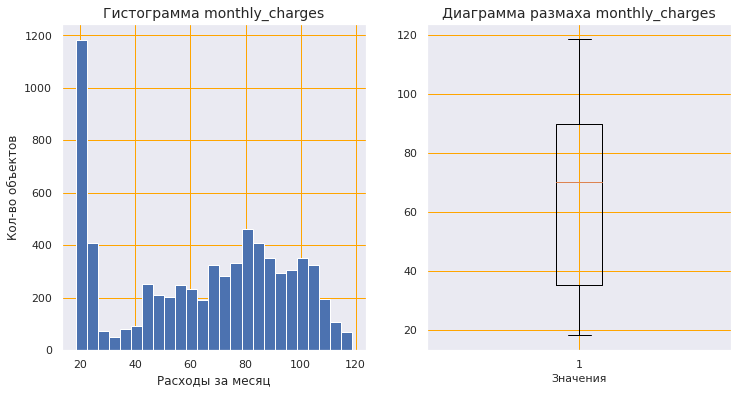

In [34]:
# Применение функции:
num_col_analyse(contract_data, num_cols[0], 'Расходы за месяц', bins=25)

- _Распределение далеко от нормального_;
- Отсутствуют выбросы;
- Больше всего в выборке представлено абонентов с месячными расходами до **20 единиц**.


Кол-во выбросов: 195


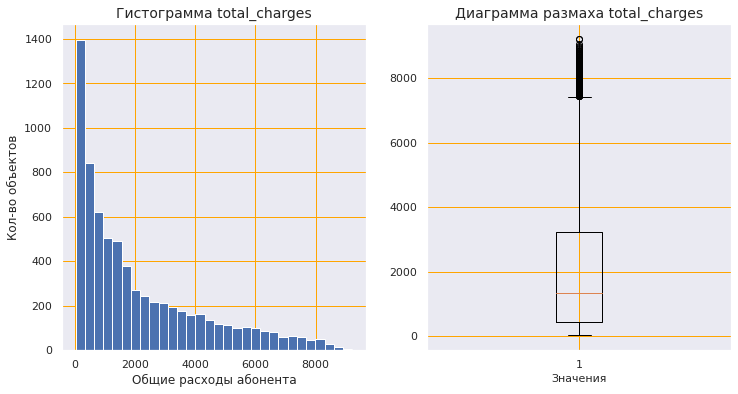

In [35]:
# Применение функции:
num_col_analyse(contract_data, num_cols[1], 'Общие расходы абонента', bins=30)

- Присутствуют выбросы, их незначительная доля;
- Данные распределены экспоненциально;
- Больше всего в выборке представлено абонентов с общими расходами до **200-500 единиц**.

Выбросы лучше не удалять, т.к. это важные наблюдения и они также должны использоваться в обучении.


Кол-во выбросов: 0


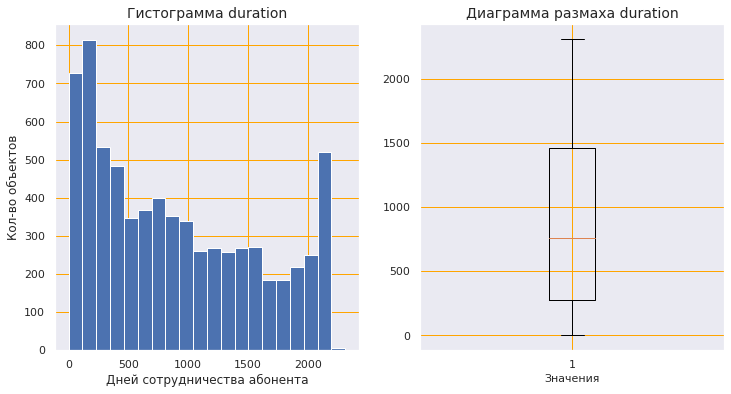

In [36]:
# Применение функции:
num_col_analyse(contract_data, num_cols[2], 'Дней сотрудничества абонента', bins=20)

- Распределение ненормальное;
- Выбросы отсутствуют;
- Больше всего представлены две группы абонентов: сотрудничающих **до 250 дней** (~ 0.7 года) и **свыше 2000 дней** (~ 5.5 лет).

#### Категориальные признаки
<br>
Аналогично объявим функции для удобства анализа:

In [37]:
# Функция для анализа кат. и дискретных признаков:

# Доп. функция для удобства сортировки на графике:
def get_order(series):
    return series.value_counts().index

# Для распределения дискретного признака:
def discrete_graph(df, column: str, hue=None,
                   xlabel: str = 'Группа абонентов', sort: bool = True,
                   rot: str = 'horizontal', stat: str = 'percent'): 
    if sort == True:
        order = get_order(df[column])
    else:
        order = None
    countplot = sns.countplot(
        data=df, 
        x=column,
        hue=hue,
        palette='flare',
        order=order,
        stat=stat)
    countplot.set_xlabel(xlabel, fontsize=12)
    
    if hue == 'target':
        countplot.set_title(f'Распределение {column} по таргету', fontsize=14)
    else:
        countplot.set_title(f'Распределение {column}', fontsize=14)
        
    plt.xticks(rotation=rot)
    
    if stat == 'percent':
        countplot.set_ylabel('Процентов от выборки, %', fontsize=12)
    else:
        countplot.set_ylabel('Количество объектов', fontsize=12)

    return plt.show()

In [38]:
# Отделяем категориальные признаки:
cat_cols = contract_data.drop(num_cols, axis=1).columns.tolist()
cat_cols.remove('customer_id')

# Проверка:
print(f'Категор. признаки для анализа: {cat_cols}')

Категор. признаки для анализа: ['type', 'paperless_billing', 'payment_method', 'target']


Приступим к анализу признаков:

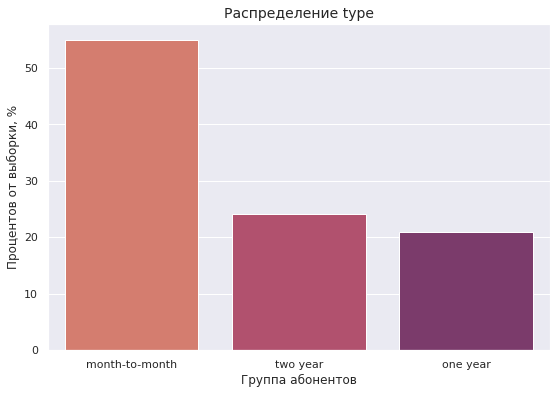

In [39]:
# Применение функции:
discrete_graph(
    contract_data,
    cat_cols[0]
)

Больше всего в выборке представлена группа абонентов с ежемесячной оплатой (55% наблюдений).

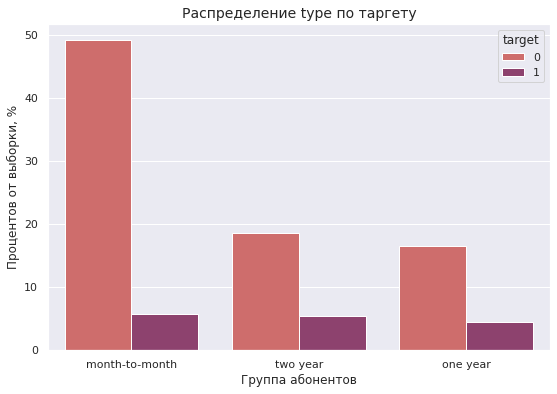

In [40]:
# Распределение по таргету:
discrete_graph(
    contract_data,
    cat_cols[0],
    hue='target'
)

Соотношение отписавшихся абонентов к оставшимся примерно одинаковое во всех группах.

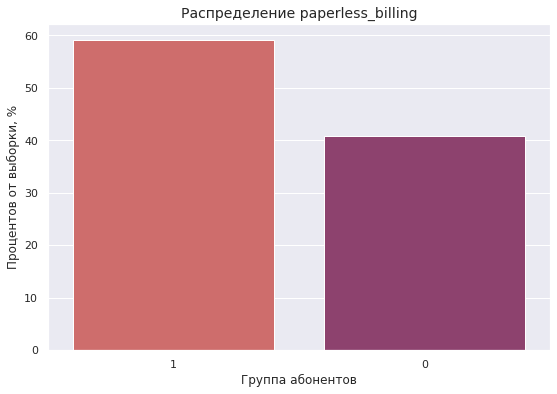

In [41]:
# Применение функции:
discrete_graph(
    contract_data,
    cat_cols[1]
)

Большинство абонентов из выборки (**59%**) предпочли получать электронный расчётный лист, нежели нет (**41%**).

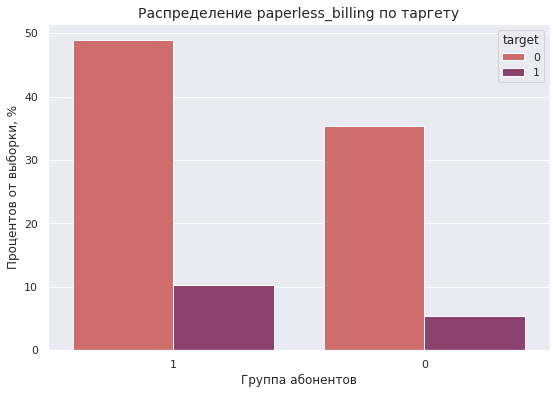

In [42]:
# Распределение по таргету:
discrete_graph(
    contract_data,
    cat_cols[1],
    hue='target'
)

Соотношение отписавшихся абонентов к оставшимся немного больше в группе получавших эл. выписку. **1:5 против 1:7**.

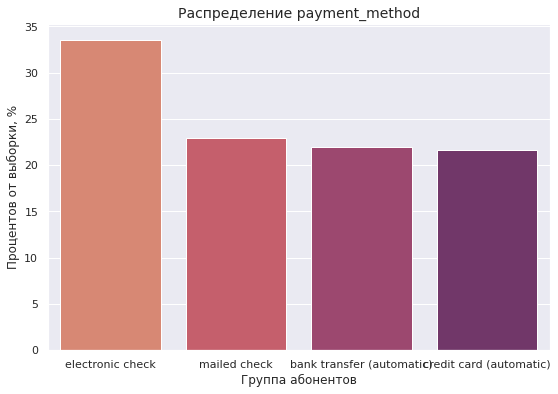

In [43]:
# Применение функции:
discrete_graph(
    contract_data,
    cat_cols[2]
)

Немного выделяется количеством группа абонентов, предпочитающих оплачивать электронным способом оплаты (**34% выборки**). Остальные три группы примерно одинаковы.

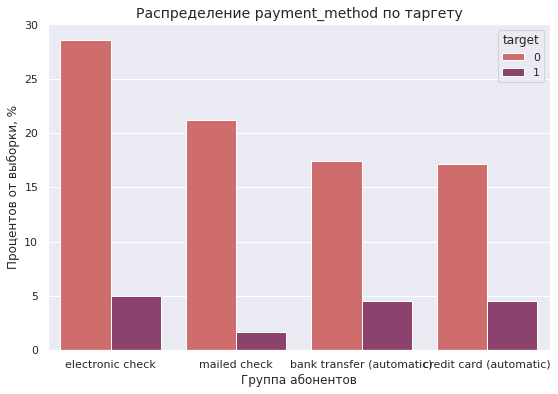

In [44]:
# Распределение по таргету:
discrete_graph(
    contract_data,
    cat_cols[2],
    hue='target'
)

Здесь можно подчеркнуть пару моментов:
- _меньше_ всего соотношение отписавшихся к оставшимся клиентам у группы `mailed_check` (оплата по чеку, направленному по почте).
- на втором месте по этому соотношению идёт группа `electrinic_check`.

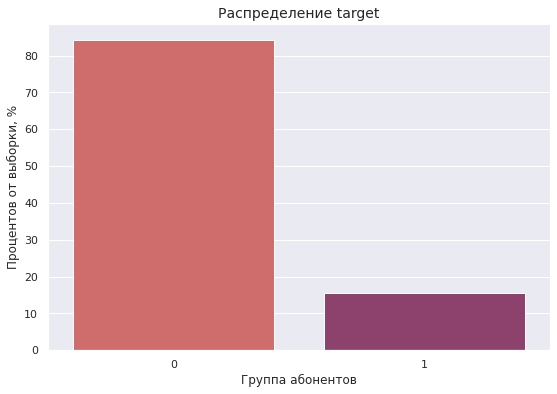

In [45]:
# Применение функции:
discrete_graph(
    contract_data,
    cat_cols[3]
)

Мы имеем дело с _дисбалансом классов_. **15% отписавшихся против 85% оставшихся абонентов**.<br><br>


### personal_data

В этом датасете нас ждут только бинарные категориальные признаки. Отберём признаки:

In [46]:
# Отбор признаков для анализа:
cat_cols = personal_data.drop('customer_id', axis=1).columns.tolist()

# Проверка:
print(f'Признаки для анализа: {cat_cols}')

Признаки для анализа: ['gender', 'senior_citizen', 'partner', 'dependents']


Также будем их смотреть по таргету, поэтому временно присоеденим его:

In [47]:
# Присоединим временно таргет:
personal_data_temp = pd.merge(
    personal_data, contract_data[['customer_id', 'target']],
    on='customer_id', how='left'
)

# Проверка:
display(personal_data_temp.head(3))
print(f'Пропусков: {personal_data_temp.isna().sum().sum()}')

,customer_id,gender,senior_citizen,partner,dependents,target
0,7590-VHVEG,female,0,1,0,0
1,5575-GNVDE,male,0,0,0,0
2,3668-QPYBK,male,0,0,0,0


Пропусков: 0


Приступим:

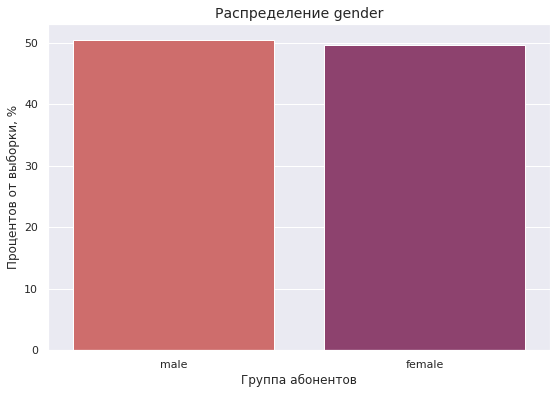

In [48]:
# Применение функции:
discrete_graph(
    personal_data_temp,
    cat_cols[0]
)

Выборка содержит почти поровну как абонентов мужского пола, так и женского.

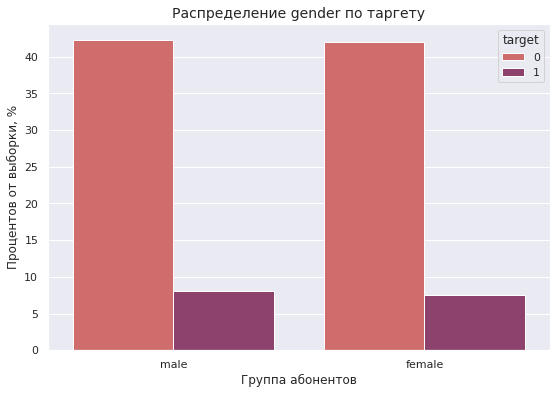

In [49]:
# Применение функции:
discrete_graph(
    personal_data_temp,
    cat_cols[0],
    hue='target'
)

_Пол, похоже, не оказывает никакого влияния на целевой признак. Обе группы почти идентичны._

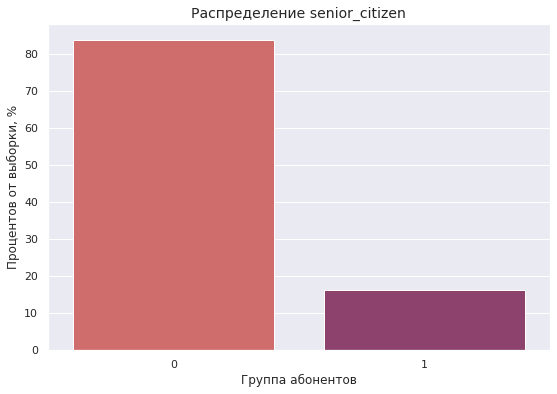

In [50]:
# Применение функции:
discrete_graph(
    personal_data_temp,
    cat_cols[1]
)

Абоненты-пенсионеры в нашей выгрузке представлены в меньшинстве. **15% против 85%**. Посмотрим, есть ли связь с таргетом:

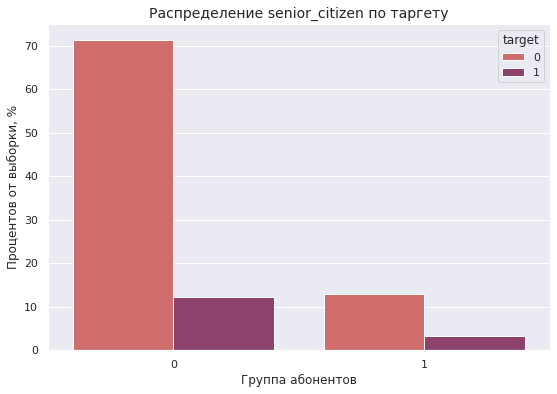

In [51]:
# Смотрим по таргету:
discrete_graph(
    personal_data_temp,
    cat_cols[1],
    hue='target'
)

_Соотношение расторгнувших договор к оставшимся **больше** у группы пенсионеров._

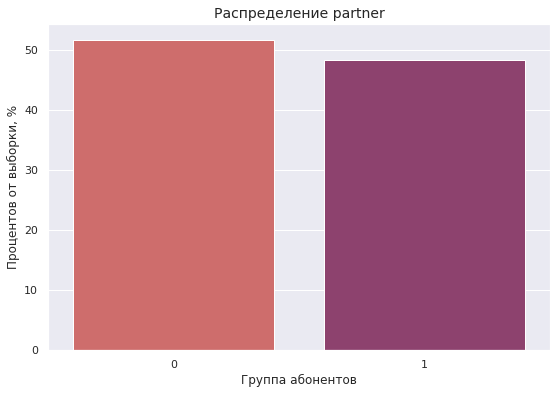

In [52]:
# Применение функции:
discrete_graph(
    personal_data_temp,
    cat_cols[2]
)

Примерно одинаково представлены официально не состоявшие в браке абоненты и состоявшие.

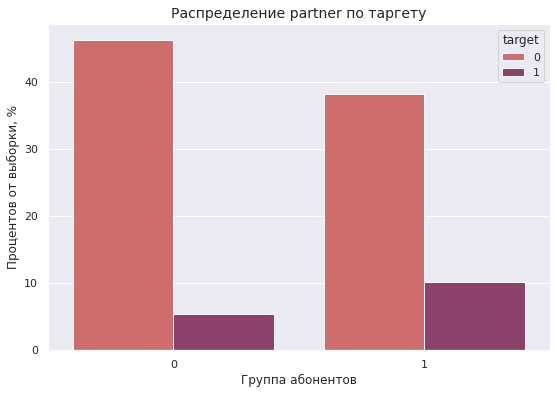

In [53]:
# Смотрим по таргету:
discrete_graph(
    personal_data_temp,
    cat_cols[2],
    hue='target'
)

Любопытно. _Среди абонентов в браке чаще встречаются те, кто расторгнул договор._

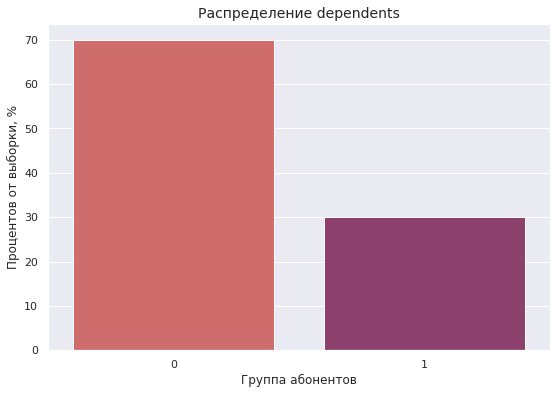

In [54]:
# Применение функции:
discrete_graph(
    personal_data_temp,
    cat_cols[3]
)

_В нашей выгрузке 70% абонентов без иждивенцев и 30% с ними._

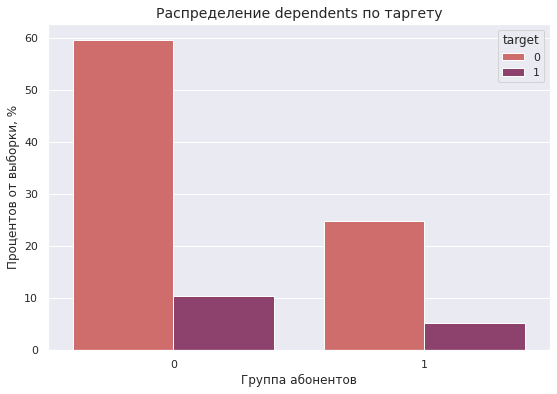

In [55]:
# Смотрим по таргету:
discrete_graph(
    personal_data_temp,
    cat_cols[3],
    hue='target'
)

Среди абонентов с иждивенцами _немного чаще_ находятся те, кто расторгнул договор.<br><br>


Удалим временную таблицу и приступим к следующей выборке:

In [56]:
# Удаление временной таблицы:
del personal_data_temp

### internet_data

Выборка, содержащая пользователей интернет-услуг. В ней так же только категориальные признаки. Отберём признаки для анализа:

In [57]:
# Отбор признаков для анализа:
cat_cols = internet_data.drop('customer_id', axis=1).columns.tolist()

# Проверка:
print(f'Признаки для анализа: {cat_cols}')

Признаки для анализа: ['internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']


In [58]:
# Присоединим временно таргет:
internet_data_temp = pd.merge(
    internet_data, contract_data[['customer_id', 'target']],
    on='customer_id', how='left'
)

# Проверка:
display(internet_data_temp.head(3))
print(f'Пропусков: {internet_data_temp.isna().sum().sum()}')

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,target
0,7590-VHVEG,dsl,0,1,0,0,0,0,0
1,5575-GNVDE,dsl,1,0,1,0,0,0,0
2,3668-QPYBK,dsl,1,1,0,0,0,0,0


Пропусков: 0


Приступим к анализу:

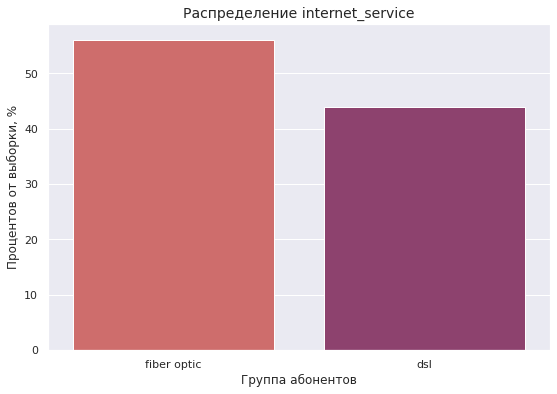

In [59]:
# Применение функции:
discrete_graph(
    internet_data_temp,
    cat_cols[0]
)

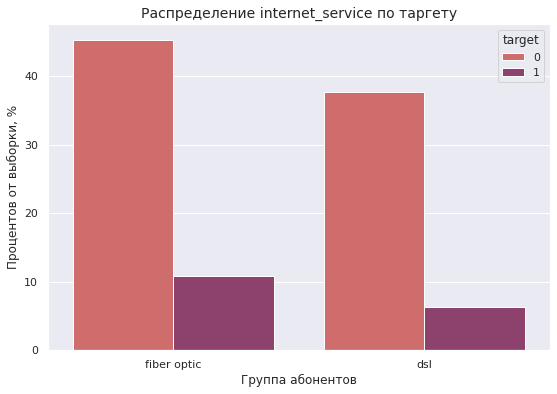

In [60]:
# По таргету:
discrete_graph(
    internet_data_temp,
    cat_cols[0],
    hue='target'
)

Каких-то сильных различий в соотношении между группами абонентов по типу подключения не наблюдается.

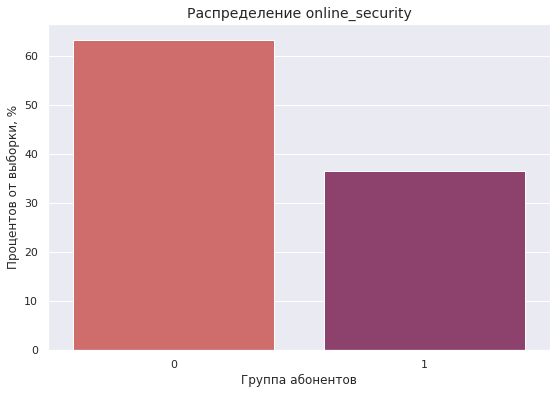

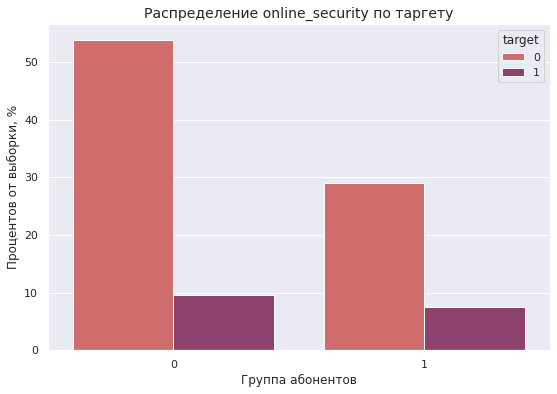

In [61]:
# Следующий признак:
discrete_graph(
    internet_data_temp,
    cat_cols[1]
)

# Он же по таргету:
discrete_graph(
    internet_data_temp,
    cat_cols[1],
    hue='target'
)

Группа абонентов, пользовавшаяся услугами блокировки опасных сайтов представлена в меньшем количестве и _при этом среди этой группы больше прекративших сотрудничество._

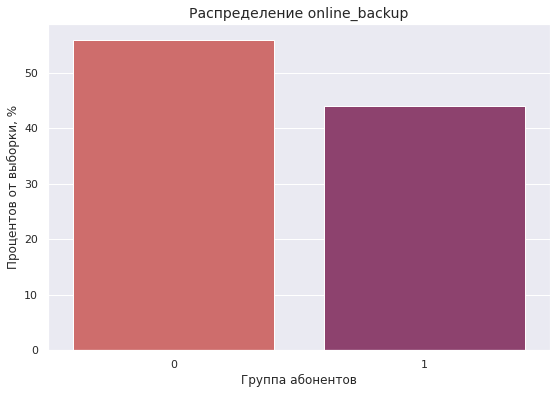

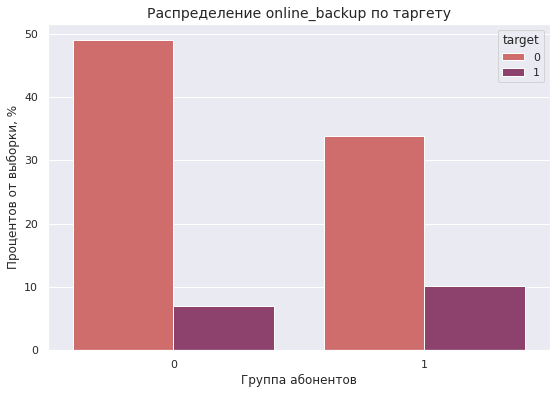

In [62]:
# Следующий признак:
discrete_graph(
    internet_data_temp,
    cat_cols[2]
)

# Он же по таргету:
discrete_graph(
    internet_data_temp,
    cat_cols[2],
    hue='target'
)

В нашей выборке немного больше абонентов, которые не пользовались услугой облачное хранилища файлов.<br>
_И среди пользователей хранилища больше отписавшихся, что интересно._

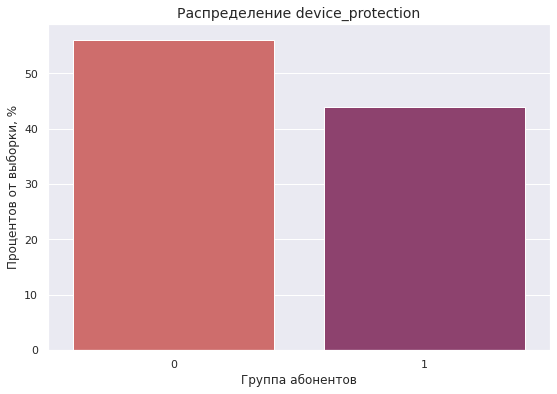

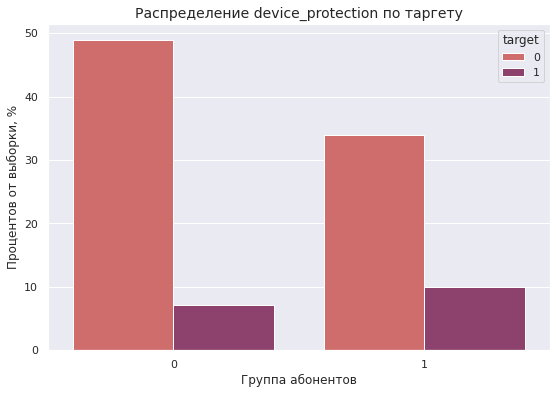

In [63]:
# Следующий признак:
discrete_graph(
    internet_data_temp,
    cat_cols[3]
)

# Он же по таргету:
discrete_graph(
    internet_data_temp,
    cat_cols[3],
    hue='target'
)

Для пользователей интернета среди тех, кто пользовался услугой антивируса, _больше отписавшихся пользователей_.

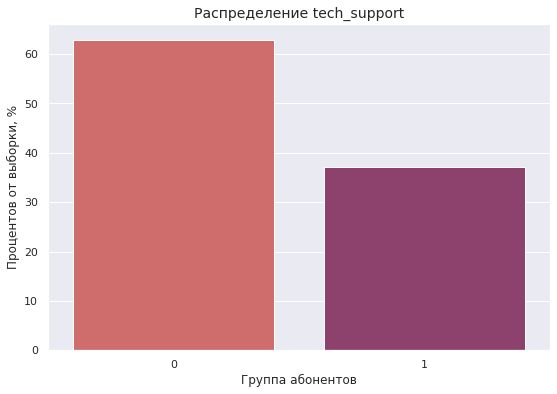

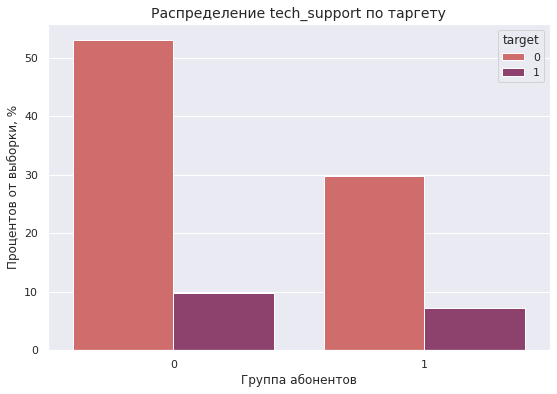

In [64]:
# Следующий признак:
discrete_graph(
    internet_data_temp,
    cat_cols[4]
)

# Он же по таргету:
discrete_graph(
    internet_data_temp,
    cat_cols[4],
    hue='target'
)

_Среди абонентов, пользовавшимися выделенной линией тех. поддержки, чаще встречаются те, кто расторгнул контракт._

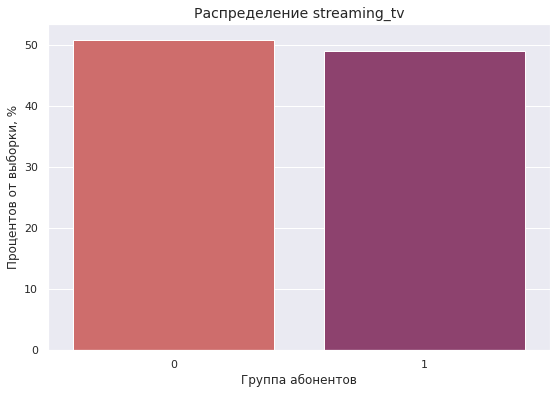

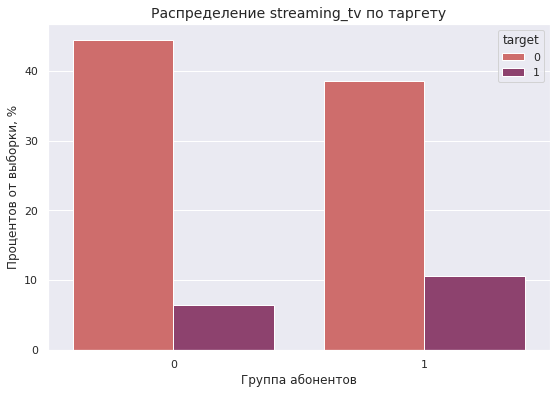

In [65]:
# Следующий признак:
discrete_graph(
    internet_data_temp,
    cat_cols[5]
)

# Он же по таргету:
discrete_graph(
    internet_data_temp,
    cat_cols[5],
    hue='target'
)

Почти поровну представлены обе группы по пользованию стриминговым телевидением, однако _среди тех, кто им пользовался, чаще встречаются расторгнутые контракты._

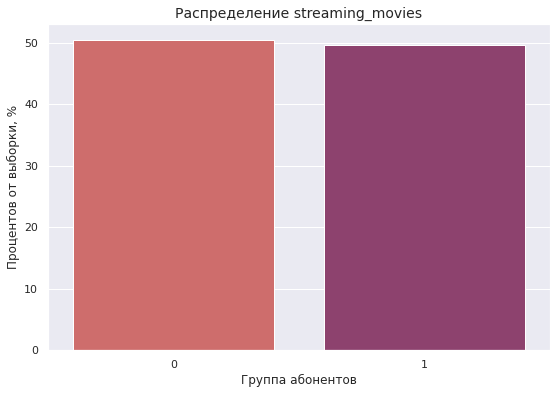

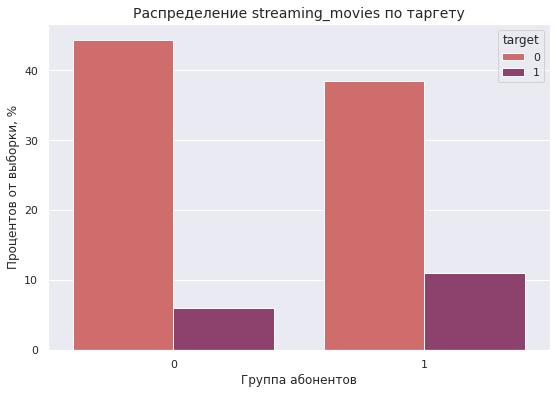

In [66]:
# Следующий признак:
discrete_graph(
    internet_data_temp,
    cat_cols[6]
)

# Он же по таргету:
discrete_graph(
    internet_data_temp,
    cat_cols[6],
    hue='target'
)

Поровну представлены обе группы по факту пользования услугой каталога фильмов.<br>
Видим ситуацию, что среди тех, кто пользовался, расторгнутых контрактов _больше_.<br><br>

Удалим временную таблицу и перейдём к следующей выгрузке.

In [67]:
# Удаление временной таблицы:
del internet_data_temp

### phone_data

Здесь всего один признак, пригодный для анализа. Рассмотрим его отдельно и через таргет:

In [68]:
# Присоединим временно таргет:
phone_data_temp = pd.merge(
    phone_data, contract_data[['customer_id', 'target']],
    on='customer_id', how='left'
)

# Проверка:
display(phone_data_temp.head(3))
print(f'Пропусков: {phone_data_temp.isna().sum().sum()}')

,customer_id,multiple_lines,target
0,5575-GNVDE,0,0
1,3668-QPYBK,0,0
2,9237-HQITU,0,0


Пропусков: 0


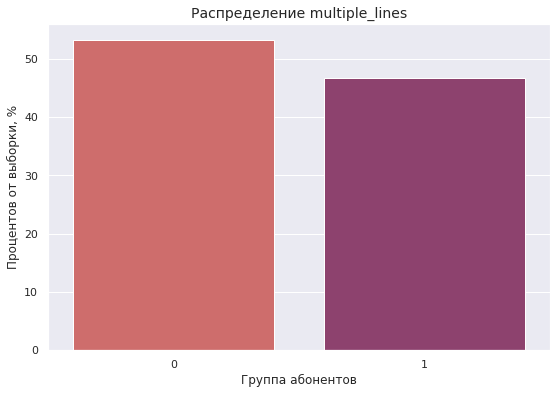

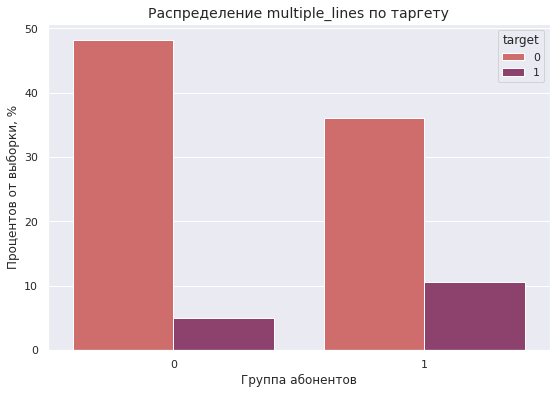

In [69]:
# Последний признак:
discrete_graph(
    phone_data_temp,
    'multiple_lines'
)

# Он же по таргету:
discrete_graph(
    phone_data_temp,
    'multiple_lines',
    hue='target'
)

_Снова наблюдаем ситуацию, что абоненты-пользователи услугой подключения телефона к нескольким линиям чаще расторгали контракт._

In [70]:
# Удаление временной таблицы:
del phone_data_temp

### Выводы

На данном этапе мы:
- Прошлись по всем входным признакам, которые потенциально могут быть использованы при обучении моделей.
- Выяснили, что не во всех признаках есть различие по соотношению значений целевого признака.
- Есть ряд признаков (в основном это доп. услуги), группа `1` в которых (т.е. пользующиеся этими услугами) содержит в себе больше тех, кто расторгнул контракт.
- Под сомнением влияние признака `gender` (пол). <br><br>


Переходим к следующему этапу.

## Объединение данных

Во всех датасетах у нас есть общий признак `customer_id` (ключ). Соединим данные по нему, чтобы подготовить их к корреляционному анализу.<br><br>
Обратим внимание на то, что кол-во объектов наших датасетах разное, потому что не все абоненты пользовались в одинаковой мере и интернетом, и телефонией. Но для предсказания нам нужны все факторы, поэтому при присоединении таблиц, содежащих информацию об **услугах** (`internet_data` и `phone_data`), мы можем вполне заполнить значением **`0`** образовавшиеся пропуски. Смысл при этом не исказится.

In [71]:
# Сохраним отдельно для лаконичности кода:
key = 'customer_id'

# Объединяем данные:
total_data = pd.merge(contract_data, personal_data, on=key, how='inner')
total_data = pd.merge(total_data, internet_data, on=key, how='left')
total_data = pd.merge(total_data, phone_data, on=key, how='left')

# Проверка:
display(total_data.head(3))
print('\n\n')

# Вывод общей информации:
total_data.info()

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,target,duration,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,month-to-month,1,electronic check,29.850000,31.040001,0,31,female,0,1,0,dsl,0.0,1.0,0.0,0.0,0.0,0.0,NaN
1,5575-GNVDE,one year,0,mailed check,56.950001,2071.840088,0,1036,male,0,0,0,dsl,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3668-QPYBK,month-to-month,1,mailed check,53.849998,226.169998,0,123,male,0,0,0,dsl,1.0,1.0,0.0,0.0,0.0,0.0,0.0





<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   int8   
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float32
 5   total_charges      7043 non-null   float32
 6   target             7043 non-null   int8   
 7   duration           7043 non-null   int16  
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int8   
 10  partner            7043 non-null   int8   
 11  dependents         7043 non-null   int8   
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   float64
 14  online_backup      5517 non-null   float64
 15  device_protection  5517 non-null   float64
 16  tech_support       55

Как мы видим образовались пропуски и из-за них изменился тип данных у ряда признаков.<br><br>

_Примечание:_<br>
Необходимо обратить внимание на признак `internet_service`, у него строковые значения и тоже есть пропуски. Это произошло по причине того, что эти абоненты не пользуются интернет услугами.<br>
Поэтому заполним их значением `not used` (не используется).


Заполним пропуски и скорректируем тип данных, ведь для бинарного признака не нужен такой огромный диапазон как `float64`.

In [72]:
# Заполняем образовавшиеся пропуски:
total_data['internet_service'].fillna('not used', inplace=True)
total_data.fillna(0, inplace=True)

# Корректируем тип данных:
total_data = change_dtypes(
    total_data,
    binary_cols=total_data.columns[13:].tolist()
)

# Проверка:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   int8   
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float32
 5   total_charges      7043 non-null   float32
 6   target             7043 non-null   int8   
 7   duration           7043 non-null   int16  
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int8   
 10  partner            7043 non-null   int8   
 11  dependents         7043 non-null   int8   
 12  internet_service   7043 non-null   object 
 13  online_security    7043 non-null   int8   
 14  online_backup      7043 non-null   int8   
 15  device_protection  7043 non-null   int8   
 16  tech_support       7043 

Теперь, когда мы корректно объединили данные, уберём признак `customer_id`, который точно нам не понадобится в обучении. После этого желательно ещё раз проверить датасет на наличие явных дубликатов.

In [73]:
# Убираем лишний признак:
total_data = total_data.drop('customer_id', axis=1)

# Проверка на дубликаты:
check_duplicates(total_data)

Кол-во явных дубликатов в датасете: 4

Кол-во явных дубликатов после обработки: 0
Кол-во объектов в датасете: 7039


### Выводы

Таким образом, на данном этапе мы:
- объединили данные в один датасет;
- избавились от образовавшихся пропусков;
- скорректировали типы данных;
- убрали признак-ключ, в обучении он не понадобится;
- убрали появившиеся явные дубликаты;
<br><br>


Cамое время перейти к корреляционному анализу данных.

## Корреляционный анализ

<br>

Для удобства построим матрицу корреляции по коэффициенту Фи в виде тепловой карты, которая поможет нам наглядно увидеть степень корреляционных связей признаками. Интерпретировать степень корреляции будем согласно _шкале Чеддока_.

Для начала объявим функцию для визуализации матрицы корреляции (МК):

In [74]:
# Функция для визуализации МК:
def correlation_matrix(df, interval_cols=None):

    # Формирование матрицы корреляции:
    phik_overview = phik_matrix(df, interval_cols=interval_cols)

    return plot_correlation_matrix(
            phik_overview.values,
            x_labels=phik_overview.columns,
            y_labels=phik_overview.index,
            vmin=0, vmax=1, color_map='Greens',
            title=(r'Матрица корреляции $\phi_K$'),
            fontsize_factor=1.5,
            figsize=(20, 15)
            )

Построим МК, обязательно указав непрерывные признаки в `interval_cols`.

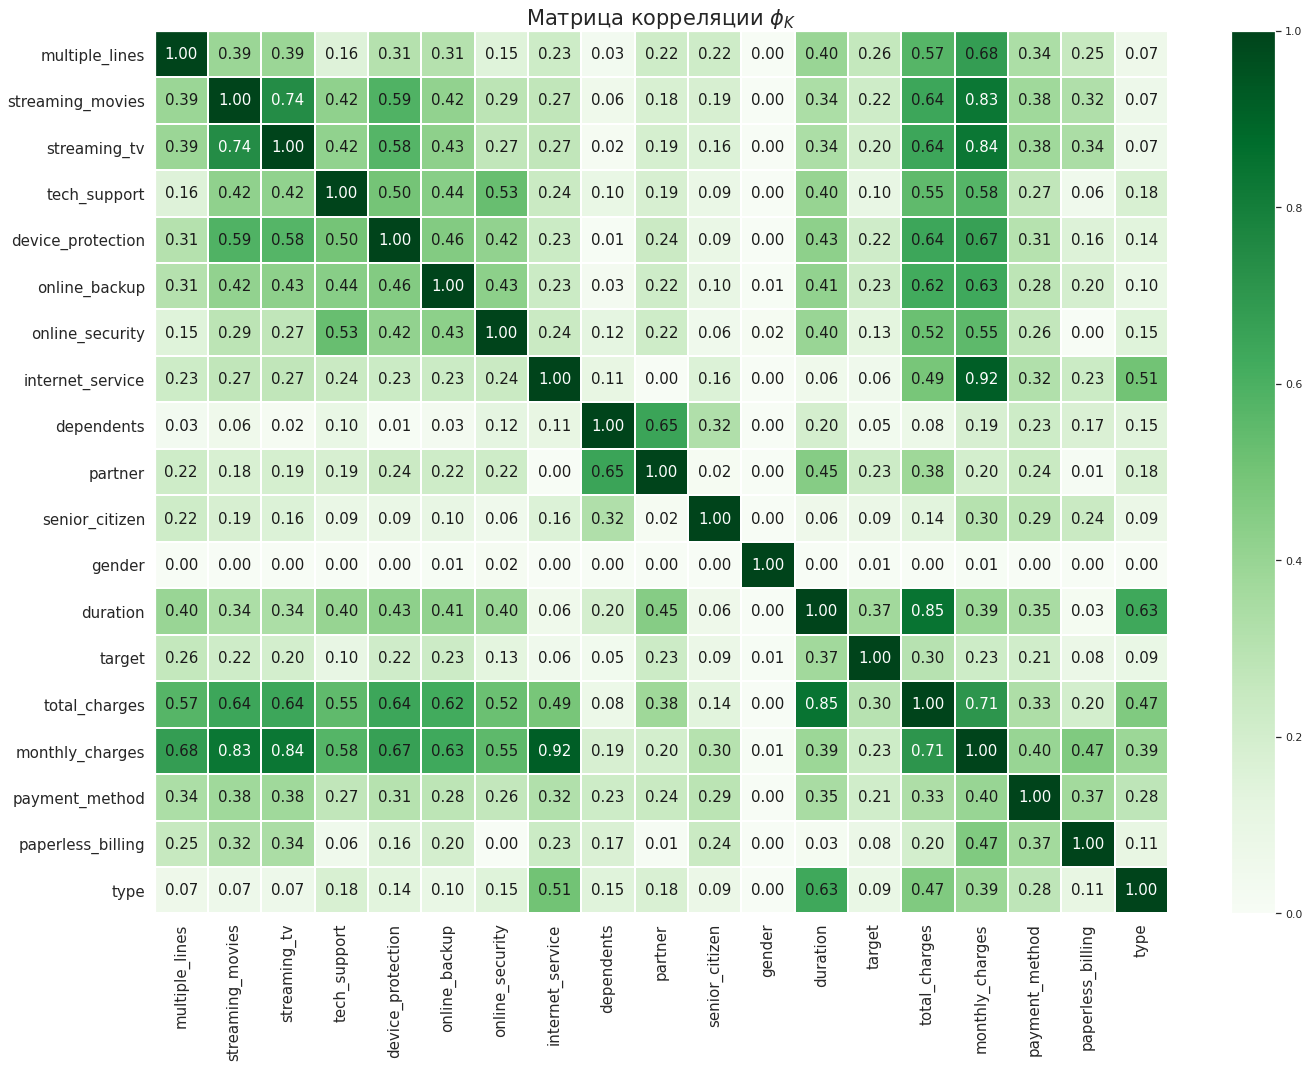

In [75]:
# Отдельно укажем непрерывные признаки:
interval_cols = ['monthly_charges', 'total_charges', 'duration']

# Построение МК:
correlation_matrix(
    total_data,
    interval_cols=interval_cols
)

Несколько инсайтов:

- Первично признак `gender` обладает нулевым коэффициентом корреляции почти со всеми признаками.
<br>

- **_Весьма высокая_** связь наблюдается между `monthly_charges` и `internet_service`.
<br>
- **_Высокая_** связь наблюдается между `duration`/`total_charges`, `streaming_tv`/`monthly_charges`, `streaming_movies`/`monthly_charges`. Также _**высокая**_ корреляция между `streaming_tv`/`streaming_movies` и `monthly_charges`/`total_charges`.
<br>

- _**Заметной**_ связью обладают `monthly_charges`/`multiple_lines`, `device_protection`/`monthly_charges`, `device_protection`/`total_charges`, `partner`/`dependents`, `online_backup`/`monthly_charges`. В целом это логично, ведь доп. услуги увеличивают расходы в месяц.
<br>

- Лучше всего с зависимой переменной коррелирует `duration`.
<br><br>


В целом и так понятно, что наличие в контракте абонента дополнительных услуг будет увеличивать его помесячные и, как следствие, общие расходы. Также тип подключения может различаться по скорости и из-за этого по цене. ~Поэтому попробуем убрать признаки `monthly_charges`, `total_charges` и `gender` как неинформативный.~

_**UPD**_: убирая какие-либо признаки впоследствии я выяснил, что у моделей ухудшается прогнозируемая способность.

### Введение дополнительных признаков

Для улучшения качества обучения стоит ввести пару новых признаков:
- Полиномиальный признак `sqrd_monthly_charges`. Это `monthly_charges` в квадрате.
- `total_monthly_ratio` — отношение общих платежей к месячному.

In [76]:
# Создание новоых признаков:
total_data['sqrd_monthly_charges'] = total_data['monthly_charges'] ** 2
total_data['total_monthly_ratio'] = total_data['total_charges'] / total_data['monthly_charges']

# Проверка:
total_data.head(3)

,type,paperless_billing,payment_method,monthly_charges,total_charges,target,duration,gender,senior_citizen,partner,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,sqrd_monthly_charges,total_monthly_ratio
0,month-to-month,1,electronic check,29.850000,31.040001,0,31,female,0,1,...,dsl,0,1,0,0,0,0,0,891.022522,1.039866
1,one year,0,mailed check,56.950001,2071.840088,0,1036,male,0,0,...,dsl,1,0,1,0,0,0,0,3243.302490,36.379982
2,month-to-month,1,mailed check,53.849998,226.169998,0,123,male,0,0,...,dsl,1,1,0,0,0,0,0,2899.822266,4.200000


Посмотрим на матрицу корреляции после изменений, не забыв при этом добавить их в список непрерывных признаков:

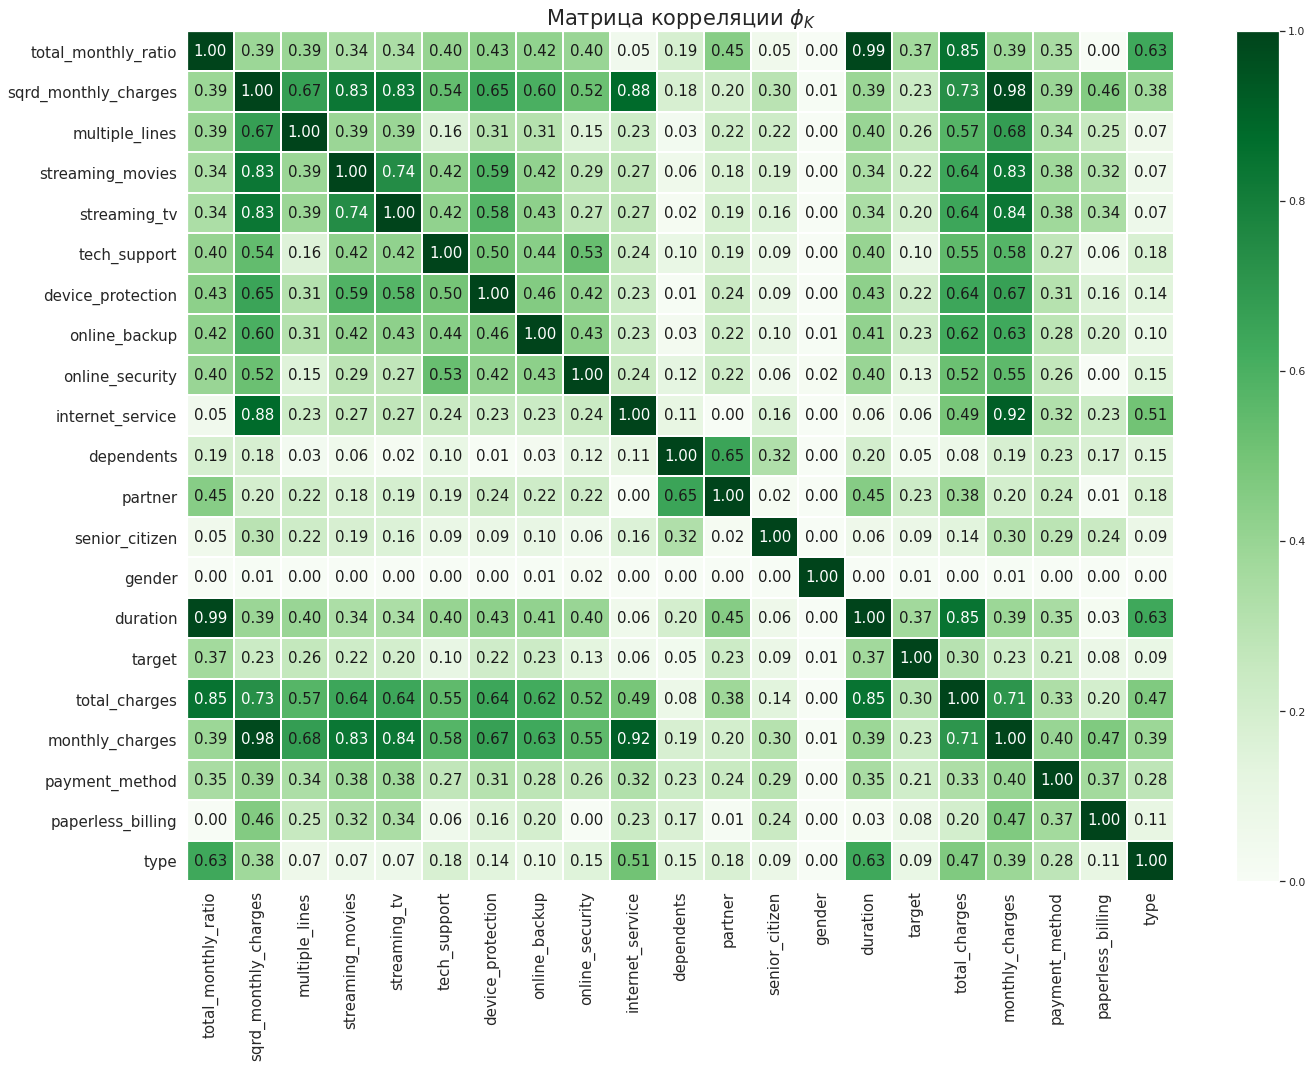

In [77]:
# Добавление новых признаков:
interval_cols.append('sqrd_monthly_charges')
interval_cols.append('total_monthly_ratio')

# Построение МК повторно:
correlation_matrix(
    total_data,
    interval_cols=interval_cols
)

**Чрезвычайно вырос** коэффициент корреляции Фи у входного признака `duration` с целевым.

### Выводы

На данном этапе мы:
- Провели корреляционный анализ данных.
- Ввели дополнительные признаки для повышения качества обучения.


Мы выяснили, что:
- признак `gender` обладает самым низким коэффициентом корреляции, однако это ни о чём не говорит. Убирая его, ухужшается результат обучения.
- лучше сохранить исходные признаки вместе с его воссозданными версиями. Это позволит модели использовать как линейные, так и нелинейные зависимости, если они существуют;

## Подготовка данных к обучению

Как мы выяснили ранее, мы имеем дело с _дисбалансом классов_. Это надо будет учесть при разделении на тренировочную и тестовую выборки.

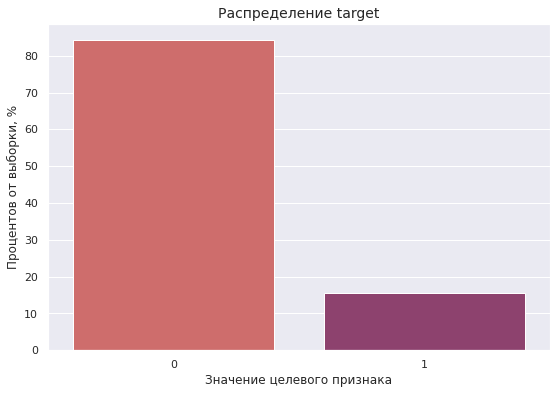

In [78]:
# Взгляд на дисбаланс:
discrete_graph(total_data, 'target', xlabel='Значение целевого признака')

Объявим функцию, с помощью которой разделим данные на тренировочную и тестовую выборки:

In [79]:
# Функция для разделения на выборки:
def get_strat_samples(df, target, test_size=TEST_SIZE,
                      random_state=RANDOM_STATE):
    X = df.drop(target, axis=1)
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        stratify=df[target],
        test_size=test_size,
        random_state=random_state)
    
    for sample in [X_train, X_test, y_train, y_test]:
        sample.reset_index(drop=True, inplace=True)
    
    print('Размер тренировочной выборки: {:.0%}'.format(X_train.shape[0] / X.shape[0]))
    print('Размер тестовой выборки: {:.0%}'.format(X_test.shape[0] / y.shape[0]))    
    return X_train, X_test, y_train, y_test

Получим выборки:

In [80]:
# Разделение на выборки:
X_train, X_test, y_train, y_test = get_strat_samples(total_data, 'target')

# Вывод размерностей:
print(f'\nОбъектов в тренировочной: {X_train.shape[0]}')
print(f'Объектов в тестовой: {X_test.shape[0]}')

Размер тренировочной выборки: 75%
Размер тестовой выборки: 25%

Объектов в тренировочной: 5279
Объектов в тестовой: 1760


Проверим корректность разделения:

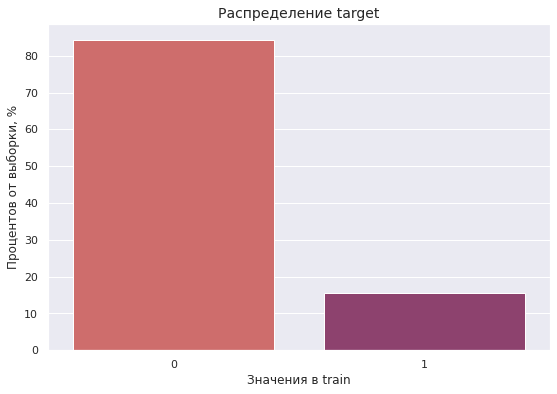

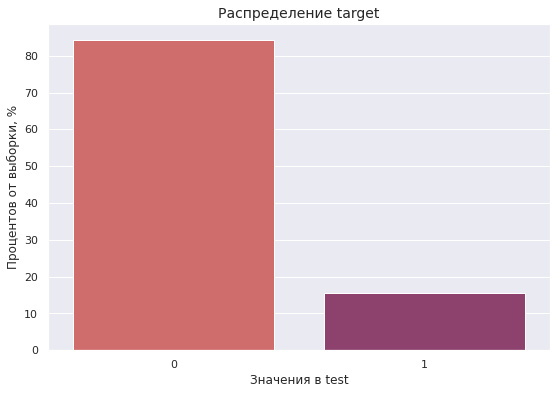

In [81]:
# Тренировочная:
discrete_graph(
    pd.DataFrame(y_train),
    'target',
    xlabel='Значения в train'
)

# Тестовая:
discrete_graph(
    pd.DataFrame(y_test),
    'target',
    xlabel='Значения в test'
)

Как мы можем наблюдать, соотношение сохранилось. Значит, разделение вышло корректным.

Далее мы будем использовать несколько моделей: **LogisticRegression**, **PassiveAggressiveClassifier**, **kNN** и **DecisionTreeClassifier** и перед тем, как дать им входные признаки, их необходимо все перевести в числовой формат.<br><br>

У нас есть 3 признака, которые необходимо закодировать, т.к. там находятся строковые значения. Сохраним их отдельно:

In [82]:
# Сохраним отдельно такие признаки:
ohe_cols = ['type', 'payment_method', 'internet_service', 'gender']

Эти признаки категориальные и не ранжируются. Поэтому корректнее будет их закодировать с помощью **`OneHotEncoder`**.<br><br>

Остальные бинарные признаки и так уже закодированы сами по себе, их трогать не будем.<br><br>


Масштабируем признак `duration` будем масштабировать с помощью **`StandardScaler`** (кроме данных для DecisionTree модели).

Объявим функции для получения выборок с изменёнными признаками:

In [83]:
# Функция для получения закодированных признаков:
def get_encoded_samples(train_data, test_data, cat_cols=ohe_cols):
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    
    X_train_ohe = encoder.fit_transform(train_data[cat_cols])
    X_test_ohe = encoder.transform(test_data[cat_cols])

    encoder_col_names = encoder.get_feature_names_out()
    
    encoded_train_features = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
    encoded_test_features = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
    return encoded_train_features, encoded_test_features

In [84]:
# Функиция для получения масштабированных признаков:
def get_scaled_samples(train_data, test_data, num_cols=interval_cols):
    scaler = StandardScaler()
    
    X_train_scaled = scaler.fit_transform(pd.DataFrame(train_data[num_cols]))
    X_test_scaled = scaler.transform(pd.DataFrame(test_data[num_cols]))

    scaled_train_features = pd.DataFrame(X_train_scaled, columns=num_cols)
    scaled_test_features = pd.DataFrame(X_test_scaled, columns=num_cols) 
    return scaled_train_features, scaled_test_features

In [85]:
# Получение выборок с изменениями:
def get_united_samples(train_data, test_data, cat_cols=ohe_cols, num_cols=interval_cols):
    encoded_train, encoded_test = get_encoded_samples(
        train_data,
        test_data,
        cat_cols=cat_cols
    )
    
    scaled_train, scaled_test = get_scaled_samples(
        train_data,
        test_data,
        num_cols=num_cols
    )
    
    conc_train = pd.concat([encoded_train, scaled_train], axis=1)
    conc_test = pd.concat([encoded_test, scaled_test], axis=1)
    
    new_train_features = pd.concat(
        [train_data.drop(cat_cols + num_cols, axis=1), conc_train], axis=1
    )
    
    new_test_features = pd.concat(
        [test_data.drop(cat_cols + num_cols, axis=1), conc_test], axis=1
    )
    return new_train_features, new_test_features

Применим объявленные функции:

In [86]:
# Формируем выборки с изменёнными признаками:
X_train_new, X_test_new = get_united_samples(X_train, X_test)

# Проверка:
print('Тренировочная:')
display(X_train_new.head(3))
print(f'Пропусков: {X_train_new.isna().sum().sum()}')
print(f'Размерность: {X_train_new.shape}\n')

print('Тестовая:')
display(X_test_new.head(3))
print(f'Пропусков: {X_test_new.isna().sum().sum()}')
print(f'Размерность: {X_test_new.shape}')

Тренировочная:


,paperless_billing,senior_citizen,partner,dependents,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,...,payment_method_electronic check,payment_method_mailed check,internet_service_fiber optic,internet_service_not used,gender_male,monthly_charges,total_charges,duration,sqrd_monthly_charges,total_monthly_ratio
0,1,0,1,1,1,1,0,0,0,1,...,0.0,1.0,0.0,0.0,1.0,0.153401,1.132991,1.581757,-0.073996,1.503987
1,1,0,1,1,1,0,1,0,0,0,...,0.0,0.0,0.0,0.0,1.0,-0.291053,-0.304739,-0.242960,-0.519326,-0.175872
2,0,0,1,0,0,0,0,0,0,0,...,0.0,1.0,0.0,1.0,1.0,-1.527505,-0.545460,0.824989,-1.262855,0.851766


Пропусков: 0
Размерность: (5279, 24)

Тестовая:


,paperless_billing,senior_citizen,partner,dependents,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,...,payment_method_electronic check,payment_method_mailed check,internet_service_fiber optic,internet_service_not used,gender_male,monthly_charges,total_charges,duration,sqrd_monthly_charges,total_monthly_ratio
0,1,0,0,0,0,0,0,0,0,0,...,1.0,0.0,1.0,0.0,1.0,0.175122,-0.755274,-0.995345,-0.049819,-0.989419
1,1,0,1,1,0,0,0,0,0,0,...,0.0,1.0,1.0,0.0,1.0,0.153401,-0.854266,-1.129752,-0.073996,-1.117009
2,1,0,0,1,1,0,1,0,1,1,...,0.0,0.0,0.0,0.0,1.0,0.460843,0.855016,0.824989,0.289147,0.851766


Пропусков: 0
Размерность: (1760, 24)


### Выводы

Таким образом, на данном этапе мы подготовили данные для обработки их алгоритмами машинного обучения.

## Обучение моделей

Подберать для моделей гиперпараметры (ГП) будем с помощью инструмента **`RandomizedSearchCV`**.<br><br>


**Примечание от заказчика**: метрика `ROC-AUC` должна быть больше **`0.85`**.

### LogisticRegression

Начнём с базовой модели лог. регрессии:

In [87]:
# Инициализация модели:
log_model = LogisticRegression(
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Определим диапазоны параметров модели для поиска:
log_params = {
    'C': [0.3, 0.5, 1],
    'warm_start': [True, False]
}

ГП задали. Запускаем поиск:

In [88]:
# Инициализация инструмента подбора:
rs_log = RandomizedSearchCV(
    log_model,
    log_params,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5,
    n_iter=10,
    random_state=RANDOM_STATE,
    verbose=2
)

# Запуск инструмента подбора:
rs_log.fit(X_train_new, y_train)
log_score = rs_log.best_score_

# Вывод результатов:
print('Лучшие гиперпараметры модели:\n\n', rs_log.best_params_)
print('\n\nМетрика ROC-AUC лучшей модели на кросс-валидации:',
      log_score.round(3))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .............................C=0.3, warm_start=True; total time=   1.3s
[CV] END .............................C=0.3, warm_start=True; total time=   0.8s
[CV] END .............................C=0.3, warm_start=True; total time=   1.2s
[CV] END .............................C=0.3, warm_start=True; total time=   1.0s
[CV] END .............................C=0.3, warm_start=True; total time=   1.1s
[CV] END ............................C=0.3, warm_start=False; total time=   1.4s
[CV] END ............................C=0.3, warm_start=False; total time=   0.8s
[CV] END ............................C=0.3, warm_start=False; total time=   1.1s
[CV] END ............................C=0.3, warm_start=False; total time=   1.0s
[CV] END ............................C=0.3, warm_start=False; total time=   1.3s
[CV] END .............................C=0.5, warm_start=True; total time=   1.1s
[CV] END .............................C=0.5, warm

Результат неплохой, но модель не справиляется с задачей.

#### Проверка на адекватность

Проверим эту модель на адекватность с помощью объявленной функции. Чтобы было более объективно, будем также применять к дамми-модели кросс-валидацию с помощью `cross_val_score`.

In [89]:
# Функция для проверки моделей:
def check_model(score, features_train=X_train_new,
                target_train=y_train, first_time=False, dummy_score=0.0):
    
    if first_time == True:
        
        # Инициализация дамми-модели:
        dummy_clf = DummyClassifier(strategy='most_frequent')
        
        # Проведение кросс-валидации для дамми-модели:
        dummy_cv = cross_val_score(
            dummy_clf,
            features_train,
            target_train,
            scoring='roc_auc',
            n_jobs=-1
        ).mean()
        
        # Получение метрики:
        print('Метрика ROC-AUC дамми-модели на кросс-валидации:',
          round(dummy_cv, 3), '=>')
    
        # Презентация результатов:
        if dummy_cv < score:
            print('=> Модель прошла проверку на адекватность.')
        else:
            print('=> Модель НЕ прошла проверку на адекватность.')
        
        return dummy_cv
            
    else:
        dummy_roc_auc = dummy_score
        if dummy_roc_auc < score:
            print('Модель прошла проверку на адекватность.')
        else:
            print('Модель НЕ прошла проверку на адекватность.')

In [90]:
# Проверка модели:
dummy_score = check_model(log_score, first_time=True)

Метрика ROC-AUC дамми-модели на кросс-валидации: 0.5 =>
=> Модель прошла проверку на адекватность.


Последующие модели также будем проверять.

### PassiveAggressiveClassifier

Попробуем данную модель из класса онлайн-алгоритмов.

In [91]:
# Инициализация модели:
pa_model = PassiveAggressiveClassifier(
    early_stopping=True,
    n_jobs=1,
    random_state=RANDOM_STATE
)

# Задаём области поиска гиперпараметров:
pa_params = {
    'C': [0.4, 0.3, 0.2, 0.1],
}

In [92]:
# Инициализация инструмента подбора:
rs_pa = RandomizedSearchCV(
    pa_model,
    pa_params,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5,
    n_iter=10,
    random_state=RANDOM_STATE,
    verbose=2
)

# Запуск инструмента подбора:
rs_pa.fit(X_train_new, y_train)
pa_score = rs_pa.best_score_

# Вывод результатов:
print('Лучшие гиперпараметры модели:\n\n', rs_pa.best_params_)
print('\n\nМетрика ROC-AUC лучшей модели на кросс-валидации:',
      pa_score.round(3))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ..............................................C=0.4; total time=   0.2s
[CV] END ..............................................C=0.4; total time=   0.3s
[CV] END ..............................................C=0.4; total time=   0.4s
[CV] END ..............................................C=0.4; total time=   0.3s
[CV] END ..............................................C=0.4; total time=   0.2s
[CV] END ..............................................C=0.3; total time=   0.4s
[CV] END ..............................................C=0.3; total time=   0.2s
[CV] END ..............................................C=0.3; total time=   0.4s
[CV] END ..............................................C=0.3; total time=   0.4s
[CV] END ..............................................C=0.3; total time=   0.3s
[CV] END ..............................................C=0.2; total time=   0.3s
[CV] END ........................................

К сожалению, результат оставляет желать лучшего.

In [93]:
# Проверка модели:
check_model(pa_score, dummy_score=dummy_score)

Модель прошла проверку на адекватность.


### CatBoostClassifier

Рассмотрим модель, основанную на бустинге.<br>Так как CatBoostClassifier умеет работать с данными в исходном виде, подадим ей для трейна исходный датасет, лишь указав в специальном параметре категориальные признаки:

In [94]:
# Сохраним отдельно список кат. признаков:
cat_features = X_train.drop(interval_cols, axis=1).columns.tolist()

# Инициализация модели:
catboost_model = CatBoostClassifier(
    iterations=1000,
    cat_features=cat_features,
    random_state=RANDOM_STATE,
    silent=True
)

# Задаём области поиска гиперпараметров:
cat_params = {
    'learning_rate': [0.2, 0.225, 0.25], 
    'depth': [2, 3, 4, 5]
}

In [95]:
# Инициализация инструмента подбора:
rs_cat = RandomizedSearchCV(
    catboost_model,
    cat_params,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5,
    n_iter=5,
    random_state=RANDOM_STATE,
    verbose=2
)

# Запуск инструмента подбора:
rs_cat.fit(X_train, y_train)
cat_score = rs_cat.best_score_

# Вывод результатов:
print('Лучшие гиперпараметры модели:\n\n', rs_cat.best_params_)
print('\n\nМетрика ROC-AUC лучшей модели на кросс-валидации:',
      cat_score.round(3))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END .......................depth=4, learning_rate=0.225; total time=   6.3s
[CV] END .......................depth=4, learning_rate=0.225; total time=   6.2s
[CV] END .......................depth=4, learning_rate=0.225; total time=   6.2s
[CV] END .......................depth=4, learning_rate=0.225; total time=   6.1s
[CV] END .......................depth=4, learning_rate=0.225; total time=   6.3s
[CV] END ........................depth=5, learning_rate=0.25; total time=   7.5s
[CV] END ........................depth=5, learning_rate=0.25; total time=   7.1s
[CV] END ........................depth=5, learning_rate=0.25; total time=   7.4s
[CV] END ........................depth=5, learning_rate=0.25; total time=   7.2s
[CV] END ........................depth=5, learning_rate=0.25; total time=   7.4s
[CV] END ........................depth=2, learning_rate=0.25; total time=   4.8s
[CV] END ........................depth=2, learnin

Модель с глубиной деревьев `2` и скоростью обучения `0.25` успешно справилась с требованием!

In [96]:
# Проверка модели:
check_model(cat_score, dummy_score=dummy_score)

Модель прошла проверку на адекватность.


### DecisionTreeClassifier

Попробуем рассмотреть модель дерева решений.

In [97]:
# Инициализация модели:
dt_model = DecisionTreeClassifier(random_state=RANDOM_STATE)

# Задаём области поиска гиперпараметров:
dt_params = {
    'max_depth': [6, 7, 8, 9, 10], 
    'max_features': [15, 20]
}

In [98]:
# Инициализация инструмента подбора:
rs_dt = RandomizedSearchCV(
    dt_model,
    dt_params,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5,
    n_iter=15,
    random_state=RANDOM_STATE,
    verbose=2
)

# Запуск инструмента подбора:
rs_dt.fit(X_train_new, y_train)
dt_score = rs_dt.best_score_

# Вывод результатов:
print('Лучшие гиперпараметры модели:\n\n', rs_dt.best_params_)
print('\n\nМетрика ROC-AUC лучшей модели на кросс-валидации:',
      dt_score.round(3))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END .......................max_depth=6, max_features=15; total time=   0.0s
[CV] END .......................max_depth=6, max_features=15; total time=   0.0s
[CV] END .......................max_depth=6, max_features=15; total time=   0.0s
[CV] END .......................max_depth=6, max_features=15; total time=   0.0s
[CV] END .......................max_depth=6, max_features=15; total time=   0.0s
[CV] END .......................max_depth=6, max_features=20; total time=   0.0s
[CV] END .......................max_depth=6, max_features=20; total time=   0.0s
[CV] END .......................max_depth=6, max_features=20; total time=   0.0s
[CV] END .......................max_depth=6, max_features=20; total time=   0.0s
[CV] END .......................max_depth=6, max_features=20; total time=   0.0s
[CV] END .......................max_depth=7, max_features=15; total time=   0.0s
[CV] END .......................max_depth=7, max

Результат чуть лучше, чем у базового лог. рега, но всё равно не дотягивает.

In [99]:
# Проверка модели:
check_model(dt_score, dummy_score=dummy_score)

Модель прошла проверку на адекватность.


### Результаты обучения


Итак, мы обучили несколько моделей МО. Представим результаты в виде таблицы и отберём лучшую модель.

In [100]:
# Построение результата в виде таблицы:
results_data = {
    'Модель': ['LogisticRegression', 'PassiveAggressive', 'CatBoost', 'DecisionTree'],
    'roc_auc_valid': [log_score, pa_score, cat_score, dt_score]
}

results = pd.DataFrame(results_data)
results.sort_values('roc_auc_valid', ascending=False).round(3)

,Модель,roc_auc_valid
2,CatBoost,0.920
3,DecisionTree,0.786
0,LogisticRegression,0.764
1,PassiveAggressive,0.702


### Выводы

На данном этапе мы обучили и подобрали лучшие наборы гиперпараметров для четырёх модели МО: базовый лог. рег., PassiveAggressiveClassifier, CatBoostClassifier и DecisionTreeClassifier. Все они прошли проверку на адекватность.

Наилучшим образом на валидации себя показала модель **CatBoostClassifier**, которая основана на бустинге. Вот с такими ГП:
- глубина деревьев `2`;
- скорость обучения `0.25`;

Опробуем эту модель на тестовых данных и посмотрим, как она справляется с задачей.

## Вывод в прод

На прошлом этапе мы выбрали лучшую модель. Самое время сделать предсказания на тестовых данных:

In [101]:
# Сохранение лучшей модели:
best_model = rs_cat.best_estimator_

# Получение вероятностей принадлежности на тестовой выборке:
prediction_probas = best_model.predict_proba(X_test)

# Расчёт метрики:
result_score = roc_auc_score(y_test, prediction_probas[:, 1])

# Вывод результата:
print('Метрика ROC-AUC лучшей модели на тестовой выборке:',
    round(result_score, 3))

Метрика ROC-AUC лучшей модели на тестовой выборке: 0.938


Отлично, модель справилась с поставленной задачей!<br>
Проверим её **`accuracy`**:

In [102]:
# Получение предсказаний на тестовой выборке:
predictions = best_model.predict(X_test)

# Расчёт метрики:
accuracy = accuracy_score(y_test, predictions)

# Вывод результата:
print('Метрика Accuracy лучшей модели на тестовой выборке:',
    round(accuracy, 3))

Метрика Accuracy лучшей модели на тестовой выборке: 0.947


Таким образом, наша модель предсказывает верно почти 95% прогнозов.

### Построение ROC-кривой

Построим ROC-кривую, чтобы графически оценить способность модели различать оба класса. 

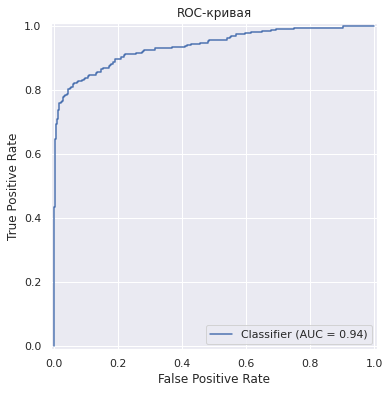

In [103]:
# Построение ROC-кривой:
RocCurveDisplay.from_predictions(y_test, prediction_probas[:,1])
plt.title('ROC-кривая')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

Модель не идеальна, но результат неплохой. Лучше качество модели сохраняется вплоть до уровня 0.8 для доли верных предсказаний класса 1 (расторгнутый контракт). С этой точки начинает резко нарастать доля неверно предсказанных объектов класса 0.<br><br>


А площадь под этой кривой и есть наша ранее высчитаная метрика ROC-AUC (0.94), что является хорошим результатом.

### Выводы

На этом этапе мы:
- инициировали "боевой" выход модели на данных, которые ранее не были никак задействованы с ней;
- модель справилась с поставленной задачей. Значение её метрики **ROC-AUC** составило **`0.938`**;
- выяснили, что она делает прогнозы верно в **94.7%** случаев;
- построили ROC-кривую для визуальной оценки качества модели;

На следующем этапе разберём, на что модель ориентируется при прогнозах.

## Анализ модели

### Важность признаков

Кратко рассмотрим, на какие признаки ориентируется модель. Отсортируем их по убыванию важности:

In [104]:
# Получим значения важности признаков:
values = best_model.feature_importances_

# Получим наименования признаков:
names = best_model.feature_names_

# Сохраним результат как таблицу:
feature_importances = pd.DataFrame(
    values,
    index=names,
    columns=['Важность признака']
).sort_values(
    by='Важность признака',
    ascending=False
)

# Вывод таблицы важности признаков:
feature_importances

,Важность признака
duration,60.461271
total_monthly_ratio,11.539039
monthly_charges,5.935410
total_charges,4.885057
type,4.626335
multiple_lines,1.927973
payment_method,1.912445
partner,1.863777
sqrd_monthly_charges,1.617833
online_backup,1.143529


Самыми _незначительными_ для предсказаний оказались `gender` и `streaming_tv`.

Для удобства выведем в графическом виде. Рассмотрим топ-5 признаков:

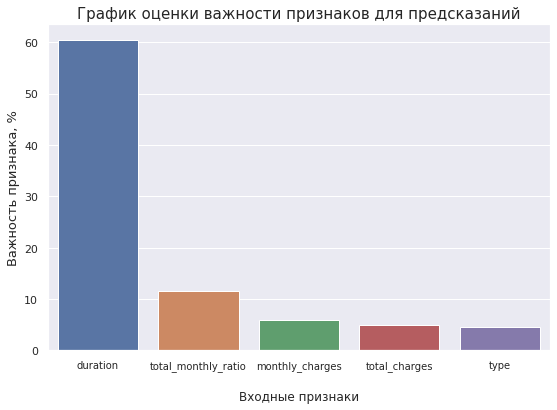

In [105]:
# Построение графика важности признаков:
sns.barplot(feature_importances.head().T)
plt.title('График оценки важности признаков для предсказаний',
         fontsize=15)
plt.xlabel('\nВходные признаки')
plt.ylabel('Важность признака, %', fontsize=13)
plt.xticks(fontsize=10);

Таким образом, чрезвычайно полезным оказался признак `duration`, который мы образовали из двух первичных: `end_date` и `begin_date`. Он с огромным отрывом лидирует по важности, она составляет **60%**!<br><br>


На втором мете оказался созданный нами ранее дополнительный признак `total_monthly_ratio`. Его важность составила `11%`.

### Построение матрицы ошибок

Рассмотрим долю ошибочных прогнозов у каждого класса путём построения _матрицы ошибок_.

In [106]:
# Расчет точности и полноты:
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)

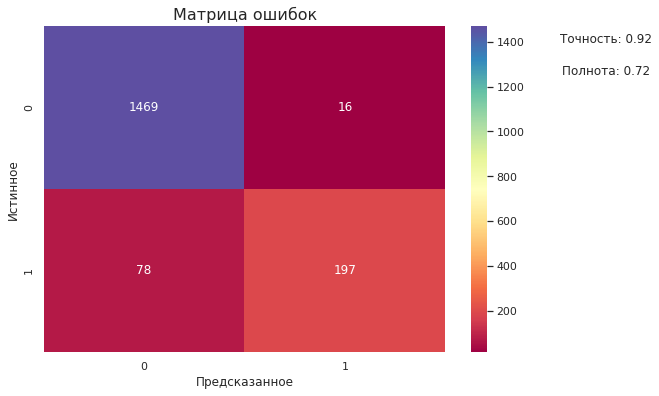

In [107]:
# Построение матрицы ошибок:
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Spectral')
plt.title('Матрица ошибок', fontsize=16)
plt.ylabel('Истинное')
plt.xlabel('Предсказанное')

# Отображение значений на графике:
plt.text(len(cm[0]) + 0.8, len(cm) - 1.9,
         f'Точность: {precision:.2f}', ha='center')

plt.text(len(cm[0]) + 0.8, len(cm) - 1.7,
         f'Полнота: {recall:.2f}', ha='center');

Таким образом, модель 16 раз ошибочно предсказала, что абонент расторгнет контракт, и **78** раз — что нет.<br> _Полнота — слабое место нашей модели. Она так себе предсказывает клиентов, расторгнувших контракты._<br><br> Что ж, далеко не идеальный результат, возможно, нужно больше данных.

### Выводы

На данном этапе мы провели краткий анализ модели:
- Построили график важности признаков (топ-5).
- Построили график матрицы ошибок, дополнительно посчитав точность и полноту для нашей модели.

Мы выяснили, что:
- самый важный признак — `duration`;
- самый неважный — `streaming_tv`;
- слабое место нашей модели — правильное предсказание класса `1` (расторгнутый контракт);

Переходим к общему выводу.

## Общий вывод

Перед нами стояла задача построения модели МО для предсказания расторжения контракта абонентом на основе имеющихся данных, то есть задача _бинарной классификации_.

Для решения этой задачи были проделаны следующие этапы:

1. Исходные данные представляли собой четыре датасета с входными признаками для объектов. С ними было проведено ознакомление и проверка соответствия их описанию:

    - исправили названия признаков;
    - подправили типы данных признаков;
    - проверили данные на явные дубликаты;


2. В процессе предобработки данных:

    - были обнаружены явные пропуски. От них мы избавились;
    - были обнаружены "неудобные" значения. Мы их изменили, чтобы затем не кодировать эти признаки; От них мы избавились.



3. Далее был проведён исследовательский анализ, на котором мы выяснили основные моменты:
    
    - В полученной выборке абоненты в среднем сотрудничают почти **900 дней**.
    - Больше всего в выборке представлено абонентов с месячными расходами **до 20 единиц**.
    - Больше всего в выборке представлено абонентов с общими расходами **до 200-500 единиц**.
    - Больше всего представлены две группы абонентов: сотрудничающих до **250 дней (~ 0.7 года)** и свыше **2000 дней (~ 5.5 лет)**.
    - **Мы имеем дело с _дисбалансом классов_. 15% отписавшихся против 85% оставшихся абонентов**.
    -  Есть ряд признаков (в основном это доп. услуги), группа пользующихся этими услугами содержит в себе больше тех, кто расторгнул контракт.


4. _Мы объедили все данные в единый датасет._ После объединения мы удалили ключ `customer_id` и объявившиеся явные дубликаты.


5. Мы провели корреляционный анализ, чтобы понять, какие признаки могут сильно влиять на качество обучения в обе стороны. В итоге было выяснено, что все признаки каким-то образом влияют на результаты обучения путём нелинейных связей между данными. Было принято решение добавить еще пару признаков, чтобы улучшить качество обучения.


6. Данные были подготовлены к обучению моделей с помощью инструментов кодирования и масштабирования признаков.


7. Далее мы обучили с помощью кросс-валидации четыре модели машинного обучения, одна из которых основаны на бустинге. Все модели, конечно, прошли проверку на адекватность и показали разные результаты (в основном неудовлетворительные), которые нам пригодились, чтобы выбрать лучшую модель.

Лучшей моделью для решения нашей задачи оказалась `CatBoostClassifier` со значением метрики **ROC-AUC** в `0.92` на кросс-валидации и **`0.938`** на проде (тестовых данных). Также мы выяснили, что она делает прогнозы верно в `94.7%` случаев.

Гиперпараметры лучшей модели:

    - глубина деревьев 2;
    - скорость обучения 0.25;

8. Впоследстии был проведён анализ этой модели и мы выяснили, какие признаки больше всего оказывают влияние на предсказания:

    - Наибольшее влияние на предсказания модели оказывает созданный признак `длительность сотрудничества`.
    
    - Наименьшее влияние оказывают признаки `пол абонента` и `использование стримингового телевидения`.

_Также мы выяснили, что предсказание клиентов, расторгнувших контракты является наиболее уязвим местом модели._ Возможно, требуется больше данных или больше признаков.
    
**Советы для бизнеса: обратить внимание на срок сотрудничества абонентов с компанией. Например, можно придумать скидки и прочие преимущества для «старожилов» путём плавного повышения процента скидки на доп. услуги с достижением "контрольных" сроков сотрудничества.**